# Setup

Once we have a virtual environment set up with ```conda create --name ghostipy python=3.6```, we can install
the relevant packages:
1. ```pip install nelpy```
2. ```pip install ghostipy```

In [1]:
import nelpy as nel
import ghostipy as gsp
import numpy as np
import h5py as h5
import tqdm
import scipy.signal as sig
import matplotlib.pyplot as plt
from os import path, remove
from contextlib import ExitStack
from scipy.interpolate import interp1d
from multiprocessing import cpu_count

/home/jchu/code/nelpy/nelpy/plotting/decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


# Interpolation

Suppose we have a raw data file where the timestamps are floats. First we need to figure out how large our file (with interpolated data) is going to be. For this example, we will interpolate no more than 40 points

In [3]:
fs = 30000
max_interp_points = 40

in_filepath = '/home/jchu/DataHDD/install_07-09-2017_0200_0400_sd09.hdf5'
with h5.File(in_filepath, 'r') as f:
    # Convert the floats to ints. Much easier to interpolate
    ts = np.round(f['timestamps'][:] * fs).astype(int)
if not nel.utils.is_sorted(ts):
    raise ValueError("Timestamps are not monotonic increasing!")

# Use the timestamps vector to find where the contiguous segments are
cont_inds = nel.utils.get_contiguous_segments(ts,
                                              step=1,
                                              index=True, 
                                              inclusive=True,
                                              assume_sorted=True)
print(f"Number of contiguous segments: {cont_inds.shape[0]}")

ts_bounds = np.zeros(cont_inds.shape, dtype='<i8')
for ii, (start, stop) in enumerate(cont_inds):
    ts_bounds[ii, 0] = ts[start]
    ts_bounds[ii, 1] = ts[stop]

# differences between segments, excluding the segment bounds
# ex: if a segment ends at 4 and begins at 7, this should return 2
gaps = ts_bounds[1:, 0] - ts_bounds[:-1, 1] - 1

interpolate = gaps <= max_interp_points

# figure out file size
n_samples_wo_gaps = np.sum(cont_inds[:,  1] - cont_inds[:, 0] + 1)
n_samples = int(n_samples_wo_gaps + np.sum(gaps[interpolate]))

print(f"Number of samples before interpolating: {n_samples_wo_gaps}")
print(f"Number of samples after  interpolating: {n_samples}")

Number of contiguous segments: 1104
Number of samples before interpolating: 226620087
Number of samples after  interpolating: 226637432


In [107]:
ts_bounds

array([[        0,       299],
       [      316,    497357],
       [   497373,    621648],
       ...,
       [225862981, 226080037],
       [226080054, 226577156],
       [226577175, 226642468]], dtype=uint32)

In [142]:
gaps

array([16, 15, 18, ..., 28, 16, 18])

Once we interpolate, the number of contiguous segments will shrink since we're filling in data. Let's figure out how many segments our output file will now have.

In [5]:
n_segments_after_interp = cont_inds.shape[0] - np.sum(interpolate)
n_segments_after_interp

49

When we create the output file, we will embed the segment information. It is a 2D array of shape (n_segments, 2). Each row consists of an entry [start, stop] denoting the time bounds for a half-open interval, i.e. [start, stop). This information is used to construct an EpochArray. Note that the units should be converted to actual time.

In [6]:
n_chunk_elements = 10000

in_filepath = '/home/jchu/DataHDD/install_07-09-2017_0200_0400_sd09.hdf5'
out_filepath = '/home/jchu/DataHDD/install_07-09-2017_0200_0400_sd09-interp.hdf5'
with ExitStack() as stack:
    infile = stack.enter_context(h5.File(in_filepath, 'r'))
    outfile = stack.enter_context(h5.File(out_filepath, 'w'))
    
    in_ts = infile['timestamps']
    in_data = infile['chdata']
    
    n_channels = in_data.shape[0]

    out_ts = outfile.create_dataset('timestamps', shape=(n_samples,),
                                    dtype='<f8', chunks=(n_chunk_elements,))
    out_data = outfile.create_dataset('chdata', shape=(n_channels, n_samples),
                                     dtype='<i2', chunks=(n_channels, n_chunk_elements))
    epoch_data = outfile.create_dataset('epochs', shape=(n_segments_after_interp, 2),
                                        dtype='<f8')
    out_ts.attrs['sampling_rate'] = fs

    out_marker = 0
    in_marker = 0
    # After each contiguous segment is written, the interp_flags will be used to determine
    # if the gap region immediately following the contiguous segment should be interpolated
    interp_flags = np.hstack((interpolate, np.array([False], dtype=np.bool)))
    for segment, ((start_idx, stop_idx), interp_flag) in tqdm.tqdm(enumerate(zip(cont_inds, interp_flags))):

        n_chunks, mod = divmod(stop_idx - start_idx + 1, n_chunk_elements)
        if mod:
            n_chunks += 1

        in_marker = start_idx
        for chunk in range(n_chunks):
            if chunk == n_chunks - 1:
                segment_data = in_data[:, in_marker:stop_idx + 1]
                segment_ts = in_ts[in_marker:stop_idx + 1]
                n = segment_data.shape[1]
                out_data[:, out_marker:out_marker + n] = segment_data
                out_ts[out_marker:out_marker + n] = segment_ts
                in_marker += n
                out_marker += n
            else:
                n = n_chunk_elements
                out_data[:, out_marker:out_marker+n] = in_data[:, in_marker:in_marker+n]
                out_ts[out_marker:out_marker + n] = in_ts[in_marker:in_marker+n]
                in_marker += n
                out_marker += n

        if interp_flag:
            bounds1 = in_data[:, stop_idx:stop_idx+1] # maintains shape, so still 2D
            bounds2 = in_data[:, stop_idx + 1:stop_idx+2]

            # use integer timestamps to generate interpolation object and do
            # interpolation
            f = interp1d(np.array([int(np.round(in_ts[stop_idx] * fs)),
                                   int(np.round(in_ts[stop_idx + 1] * fs))]),
                         np.hstack((bounds1, bounds2)))

            interp_ts = np.arange(int(np.round(in_ts[stop_idx] * fs)) + 1,
                                  int(np.round(in_ts[stop_idx + 1] * fs)))
            interp_data = f(interp_ts)
            n_interp_samples = interp_data.shape[1]
            
            print(f"Interpolating after segment {segment}, {n_interp_samples} data points")
            out_ts[out_marker:out_marker + n_interp_samples] = interp_ts / fs
            out_data[:, out_marker:out_marker + n_interp_samples] = interp_data.astype('<i2')
            out_marker += n_interp_samples
            
    # now that we are finished, go extract the segment information of the new data
    new_cs = nel.utils.get_contiguous_segments(out_ts[:], step=1/fs)
    epoch_data[:] = new_cs

0it [00:00, ?it/s]

Interpolating after segment 0, 16 data points


2it [00:02,  1.19s/it]

Interpolating after segment 1, 15 data points


3it [00:02,  1.06it/s]

Interpolating after segment 2, 18 data points


4it [00:03,  1.00it/s]

Interpolating after segment 3, 16 data points


5it [00:04,  1.15it/s]

Interpolating after segment 4, 18 data points


6it [00:05,  1.06it/s]

Interpolating after segment 5, 16 data points


7it [00:06,  1.23it/s]

Interpolating after segment 6, 18 data points


8it [00:06,  1.23it/s]

Interpolating after segment 7, 16 data points


9it [00:07,  1.42it/s]

Interpolating after segment 8, 18 data points


10it [00:08,  1.26it/s]

Interpolating after segment 9, 15 data points


11it [00:08,  1.38it/s]

Interpolating after segment 10, 18 data points


12it [00:10,  1.04s/it]

Interpolating after segment 11, 16 data points


13it [00:11,  1.05it/s]

Interpolating after segment 12, 18 data points


14it [00:13,  1.15s/it]

Interpolating after segment 13, 16 data points


15it [00:14,  1.18s/it]

Interpolating after segment 14, 18 data points


16it [00:15,  1.18s/it]

Interpolating after segment 15, 15 data points


17it [00:16,  1.01it/s]

Interpolating after segment 16, 17 data points


18it [00:18,  1.33s/it]

Interpolating after segment 17, 15 data points


19it [00:18,  1.14s/it]

Interpolating after segment 18, 18 data points


20it [00:20,  1.37s/it]

Interpolating after segment 19, 16 data points


21it [00:21,  1.27s/it]

Interpolating after segment 20, 18 data points


22it [00:23,  1.43s/it]

Interpolating after segment 21, 18 data points


23it [00:24,  1.43s/it]

Interpolating after segment 22, 15 data points


24it [00:27,  1.83s/it]

Interpolating after segment 23, 19 data points


25it [00:29,  1.76s/it]

Interpolating after segment 24, 16 data points


26it [00:33,  2.52s/it]

Interpolating after segment 25, 18 data points


27it [00:35,  2.43s/it]

Interpolating after segment 26, 17 data points


28it [00:38,  2.46s/it]

Interpolating after segment 27, 19 data points


29it [00:39,  2.08s/it]

Interpolating after segment 28, 16 data points


30it [00:40,  1.65s/it]

Interpolating after segment 29, 18 data points


32it [00:44,  1.87s/it]

Interpolating after segment 31, 16 data points


33it [00:48,  2.61s/it]

Interpolating after segment 32, 18 data points


34it [00:50,  2.36s/it]

Interpolating after segment 33, 18 data points


35it [00:52,  2.39s/it]

Interpolating after segment 34, 16 data points


36it [00:55,  2.34s/it]

Interpolating after segment 35, 18 data points


37it [00:56,  2.12s/it]

Interpolating after segment 36, 15 data points


39it [01:01,  2.27s/it]

Interpolating after segment 38, 16 data points


40it [01:04,  2.45s/it]

Interpolating after segment 39, 17 data points


41it [01:05,  2.05s/it]

Interpolating after segment 40, 16 data points


42it [01:07,  1.96s/it]

Interpolating after segment 41, 16 data points


43it [01:08,  1.54s/it]

Interpolating after segment 42, 18 data points


44it [01:09,  1.58s/it]

Interpolating after segment 43, 15 data points


45it [01:14,  2.41s/it]

Interpolating after segment 44, 18 data points


46it [01:15,  2.02s/it]

Interpolating after segment 45, 16 data points


48it [01:18,  1.83s/it]

Interpolating after segment 47, 15 data points


49it [01:19,  1.57s/it]

Interpolating after segment 48, 17 data points


50it [01:21,  1.75s/it]

Interpolating after segment 49, 15 data points


51it [01:22,  1.61s/it]

Interpolating after segment 50, 17 data points


52it [01:23,  1.43s/it]

Interpolating after segment 51, 17 data points


53it [01:24,  1.23s/it]

Interpolating after segment 52, 17 data points


54it [01:26,  1.53s/it]

Interpolating after segment 53, 15 data points


55it [01:27,  1.36s/it]

Interpolating after segment 54, 18 data points


56it [01:29,  1.56s/it]

Interpolating after segment 55, 15 data points


57it [01:30,  1.39s/it]

Interpolating after segment 56, 17 data points


58it [01:31,  1.29s/it]

Interpolating after segment 57, 15 data points


59it [01:32,  1.19s/it]

Interpolating after segment 58, 18 data points


60it [01:33,  1.15s/it]

Interpolating after segment 59, 17 data points


61it [01:36,  1.53s/it]

Interpolating after segment 60, 18 data points


62it [01:37,  1.59s/it]

Interpolating after segment 61, 16 data points


63it [01:41,  2.06s/it]

Interpolating after segment 62, 18 data points


64it [01:41,  1.65s/it]

Interpolating after segment 63, 20 data points


65it [01:43,  1.77s/it]

Interpolating after segment 64, 17 data points


66it [01:46,  1.99s/it]

Interpolating after segment 65, 18 data points


67it [01:48,  1.94s/it]

Interpolating after segment 66, 16 data points


68it [01:48,  1.57s/it]

Interpolating after segment 67, 18 data points


69it [01:49,  1.40s/it]

Interpolating after segment 68, 15 data points


70it [01:50,  1.12s/it]

Interpolating after segment 69, 19 data points


71it [01:50,  1.06it/s]

Interpolating after segment 70, 28 data points


72it [01:52,  1.13s/it]

Interpolating after segment 71, 15 data points


73it [01:53,  1.18s/it]

Interpolating after segment 72, 17 data points


74it [01:56,  1.65s/it]

Interpolating after segment 73, 18 data points


75it [01:57,  1.48s/it]

Interpolating after segment 74, 16 data points


76it [01:58,  1.26s/it]

Interpolating after segment 75, 18 data points


77it [02:00,  1.47s/it]

Interpolating after segment 76, 15 data points


78it [02:00,  1.15s/it]

Interpolating after segment 77, 17 data points


79it [02:02,  1.44s/it]

Interpolating after segment 78, 15 data points


80it [02:05,  1.96s/it]

Interpolating after segment 79, 15 data points


81it [02:06,  1.60s/it]

Interpolating after segment 80, 19 data points


82it [02:07,  1.46s/it]

Interpolating after segment 81, 16 data points


83it [02:08,  1.19s/it]

Interpolating after segment 82, 17 data points


84it [02:11,  1.71s/it]

Interpolating after segment 83, 18 data points


85it [02:13,  1.96s/it]

Interpolating after segment 84, 16 data points


86it [02:14,  1.72s/it]

Interpolating after segment 85, 18 data points


87it [02:16,  1.57s/it]

Interpolating after segment 86, 15 data points


88it [02:16,  1.32s/it]

Interpolating after segment 87, 18 data points


89it [02:18,  1.29s/it]

Interpolating after segment 88, 15 data points


90it [02:18,  1.05s/it]

Interpolating after segment 89, 17 data points


92it [02:20,  1.06it/s]

Interpolating after segment 91, 15 data points


93it [02:21,  1.02it/s]

Interpolating after segment 92, 18 data points


94it [02:23,  1.28s/it]

Interpolating after segment 93, 16 data points


95it [02:24,  1.09s/it]

Interpolating after segment 94, 18 data points


96it [02:25,  1.11s/it]

Interpolating after segment 95, 15 data points


97it [02:26,  1.13s/it]

Interpolating after segment 96, 17 data points


99it [02:28,  1.00it/s]

Interpolating after segment 98, 15 data points


100it [02:29,  1.01it/s]

Interpolating after segment 99, 19 data points


101it [02:30,  1.21s/it]

Interpolating after segment 100, 16 data points


102it [02:31,  1.10s/it]

Interpolating after segment 101, 18 data points


103it [02:33,  1.20s/it]

Interpolating after segment 102, 16 data points


104it [02:34,  1.12s/it]

Interpolating after segment 103, 18 data points


105it [02:35,  1.14s/it]

Interpolating after segment 104, 16 data points


106it [02:35,  1.07it/s]

Interpolating after segment 105, 17 data points


107it [02:37,  1.30s/it]

Interpolating after segment 106, 15 data points


108it [02:39,  1.35s/it]

Interpolating after segment 107, 19 data points


109it [02:40,  1.35s/it]

Interpolating after segment 108, 16 data points


110it [02:41,  1.26s/it]

Interpolating after segment 109, 18 data points


111it [02:42,  1.20s/it]

Interpolating after segment 110, 15 data points


112it [02:43,  1.01it/s]

Interpolating after segment 111, 18 data points


114it [02:45,  1.10it/s]

Interpolating after segment 113, 16 data points


115it [02:45,  1.21it/s]

Interpolating after segment 114, 18 data points


116it [02:47,  1.23s/it]

Interpolating after segment 115, 16 data points


117it [02:49,  1.27s/it]

Interpolating after segment 116, 18 data points


118it [02:50,  1.29s/it]

Interpolating after segment 117, 16 data points


119it [02:51,  1.14s/it]

Interpolating after segment 118, 17 data points


120it [02:52,  1.16s/it]

Interpolating after segment 119, 15 data points


121it [02:53,  1.05s/it]

Interpolating after segment 120, 18 data points


122it [02:55,  1.32s/it]

Interpolating after segment 121, 16 data points


123it [02:56,  1.15s/it]

Interpolating after segment 122, 18 data points


124it [02:57,  1.23s/it]

Interpolating after segment 123, 15 data points


125it [02:58,  1.24s/it]

Interpolating after segment 124, 18 data points


126it [03:00,  1.33s/it]

Interpolating after segment 125, 15 data points


127it [03:00,  1.11s/it]

Interpolating after segment 126, 17 data points


129it [03:02,  1.02s/it]

Interpolating after segment 128, 15 data points


130it [03:03,  1.03it/s]

Interpolating after segment 129, 18 data points


131it [03:04,  1.02s/it]

Interpolating after segment 130, 39 data points


132it [03:05,  1.06it/s]

Interpolating after segment 131, 15 data points


133it [03:06,  1.08it/s]

Interpolating after segment 132, 17 data points


134it [03:07,  1.11s/it]

Interpolating after segment 133, 15 data points


135it [03:08,  1.01s/it]

Interpolating after segment 134, 18 data points


136it [03:10,  1.11s/it]

Interpolating after segment 135, 15 data points


137it [03:10,  1.05it/s]

Interpolating after segment 136, 17 data points


138it [03:12,  1.32s/it]

Interpolating after segment 137, 15 data points


139it [03:13,  1.26s/it]

Interpolating after segment 138, 18 data points


140it [03:15,  1.41s/it]

Interpolating after segment 139, 16 data points


141it [03:16,  1.26s/it]

Interpolating after segment 140, 17 data points


142it [03:17,  1.18s/it]

Interpolating after segment 141, 15 data points


143it [03:18,  1.00s/it]

Interpolating after segment 142, 18 data points


144it [03:20,  1.32s/it]

Interpolating after segment 143, 16 data points


145it [03:20,  1.06s/it]

Interpolating after segment 144, 18 data points


146it [03:22,  1.32s/it]

Interpolating after segment 145, 15 data points


147it [03:23,  1.24s/it]

Interpolating after segment 146, 18 data points


148it [03:25,  1.30s/it]

Interpolating after segment 147, 15 data points


149it [03:25,  1.13s/it]

Interpolating after segment 148, 17 data points


150it [03:27,  1.13s/it]

Interpolating after segment 149, 15 data points


151it [03:27,  1.03it/s]

Interpolating after segment 150, 18 data points


152it [03:29,  1.28s/it]

Interpolating after segment 151, 17 data points


153it [03:30,  1.15s/it]

Interpolating after segment 152, 18 data points


154it [03:32,  1.27s/it]

Interpolating after segment 153, 15 data points


155it [03:33,  1.25s/it]

Interpolating after segment 154, 18 data points


156it [03:34,  1.23s/it]

Interpolating after segment 155, 16 data points


157it [03:35,  1.12s/it]

Interpolating after segment 156, 18 data points


158it [03:37,  1.35s/it]

Interpolating after segment 157, 15 data points


159it [03:37,  1.13s/it]

Interpolating after segment 158, 18 data points


160it [03:39,  1.39s/it]

Interpolating after segment 159, 15 data points


161it [03:40,  1.32s/it]

Interpolating after segment 160, 17 data points


162it [03:42,  1.33s/it]

Interpolating after segment 161, 15 data points


163it [03:42,  1.14s/it]

Interpolating after segment 162, 17 data points


164it [03:44,  1.14s/it]

Interpolating after segment 163, 15 data points


165it [03:44,  1.05s/it]

Interpolating after segment 164, 17 data points


166it [03:46,  1.33s/it]

Interpolating after segment 165, 15 data points


167it [03:47,  1.24s/it]

Interpolating after segment 166, 17 data points


168it [03:49,  1.41s/it]

Interpolating after segment 167, 15 data points


169it [03:50,  1.32s/it]

Interpolating after segment 168, 17 data points


170it [03:52,  1.31s/it]

Interpolating after segment 169, 15 data points


171it [03:52,  1.12s/it]

Interpolating after segment 170, 17 data points


172it [03:54,  1.33s/it]

Interpolating after segment 171, 14 data points


173it [03:55,  1.13s/it]

Interpolating after segment 172, 18 data points


174it [03:57,  1.38s/it]

Interpolating after segment 173, 15 data points


175it [03:58,  1.26s/it]

Interpolating after segment 174, 17 data points


176it [04:00,  1.43s/it]

Interpolating after segment 175, 15 data points


177it [04:00,  1.26s/it]

Interpolating after segment 176, 18 data points


178it [04:02,  1.26s/it]

Interpolating after segment 177, 16 data points


179it [04:02,  1.10s/it]

Interpolating after segment 178, 18 data points


180it [04:04,  1.31s/it]

Interpolating after segment 179, 15 data points


181it [04:05,  1.22s/it]

Interpolating after segment 180, 18 data points


182it [04:07,  1.37s/it]

Interpolating after segment 181, 16 data points


183it [04:08,  1.27s/it]

Interpolating after segment 182, 18 data points


184it [04:09,  1.28s/it]

Interpolating after segment 183, 15 data points


185it [04:10,  1.16s/it]

Interpolating after segment 184, 18 data points


187it [04:12,  1.10s/it]

Interpolating after segment 186, 18 data points


188it [04:14,  1.38s/it]

Interpolating after segment 187, 15 data points


189it [04:16,  1.30s/it]

Interpolating after segment 188, 17 data points


190it [04:17,  1.38s/it]

Interpolating after segment 189, 15 data points


191it [04:18,  1.17s/it]

Interpolating after segment 190, 17 data points


192it [04:19,  1.26s/it]

Interpolating after segment 191, 15 data points


193it [04:20,  1.13s/it]

Interpolating after segment 192, 18 data points


194it [04:22,  1.35s/it]

Interpolating after segment 193, 15 data points


195it [04:23,  1.19s/it]

Interpolating after segment 194, 17 data points


196it [04:24,  1.35s/it]

Interpolating after segment 195, 15 data points


197it [04:26,  1.28s/it]

Interpolating after segment 196, 17 data points


198it [04:27,  1.33s/it]

Interpolating after segment 197, 15 data points


199it [04:28,  1.19s/it]

Interpolating after segment 198, 18 data points


201it [04:30,  1.19s/it]

Interpolating after segment 200, 17 data points


202it [04:32,  1.43s/it]

Interpolating after segment 201, 15 data points


203it [04:33,  1.29s/it]

Interpolating after segment 202, 18 data points


204it [04:35,  1.38s/it]

Interpolating after segment 203, 15 data points


205it [04:37,  1.45s/it]

Interpolating after segment 204, 18 data points


206it [04:38,  1.31s/it]

Interpolating after segment 205, 15 data points


207it [04:38,  1.20s/it]

Interpolating after segment 206, 17 data points


208it [04:41,  1.50s/it]

Interpolating after segment 207, 15 data points


209it [04:41,  1.23s/it]

Interpolating after segment 208, 18 data points


210it [04:43,  1.40s/it]

Interpolating after segment 209, 15 data points


211it [04:44,  1.26s/it]

Interpolating after segment 210, 18 data points


212it [04:45,  1.26s/it]

Interpolating after segment 211, 16 data points


213it [04:46,  1.14s/it]

Interpolating after segment 212, 18 data points


215it [04:48,  1.07s/it]

Interpolating after segment 214, 17 data points


216it [04:51,  1.48s/it]

Interpolating after segment 215, 15 data points


217it [04:52,  1.32s/it]

Interpolating after segment 216, 17 data points


218it [04:53,  1.39s/it]

Interpolating after segment 217, 15 data points


219it [04:54,  1.26s/it]

Interpolating after segment 218, 19 data points


220it [04:55,  1.25s/it]

Interpolating after segment 219, 15 data points


221it [04:56,  1.01s/it]

Interpolating after segment 220, 17 data points


222it [04:58,  1.24s/it]

Interpolating after segment 221, 15 data points


223it [04:58,  1.13s/it]

Interpolating after segment 222, 17 data points


224it [05:01,  1.42s/it]

Interpolating after segment 223, 15 data points


225it [05:01,  1.21s/it]

Interpolating after segment 224, 17 data points


226it [05:02,  1.20s/it]

Interpolating after segment 225, 15 data points


227it [05:03,  1.09s/it]

Interpolating after segment 226, 17 data points


228it [05:05,  1.30s/it]

Interpolating after segment 227, 14 data points


229it [05:06,  1.22s/it]

Interpolating after segment 228, 17 data points


230it [05:08,  1.38s/it]

Interpolating after segment 229, 15 data points


231it [05:09,  1.27s/it]

Interpolating after segment 230, 18 data points


233it [05:11,  1.24s/it]

Interpolating after segment 232, 17 data points


234it [05:13,  1.24s/it]

Interpolating after segment 233, 15 data points


235it [05:13,  1.07s/it]

Interpolating after segment 234, 17 data points


236it [05:15,  1.31s/it]

Interpolating after segment 235, 15 data points


237it [05:16,  1.20s/it]

Interpolating after segment 236, 17 data points


238it [05:19,  1.62s/it]

Interpolating after segment 237, 15 data points


239it [05:20,  1.39s/it]

Interpolating after segment 238, 18 data points


240it [05:21,  1.32s/it]

Interpolating after segment 239, 15 data points


241it [05:22,  1.32s/it]

Interpolating after segment 240, 17 data points


242it [05:23,  1.31s/it]

Interpolating after segment 241, 15 data points


243it [05:24,  1.11s/it]

Interpolating after segment 242, 18 data points


244it [05:26,  1.36s/it]

Interpolating after segment 243, 16 data points


245it [05:27,  1.26s/it]

Interpolating after segment 244, 18 data points


246it [05:28,  1.31s/it]

Interpolating after segment 245, 15 data points


247it [05:29,  1.15s/it]

Interpolating after segment 246, 17 data points


248it [05:31,  1.28s/it]

Interpolating after segment 247, 15 data points


249it [05:32,  1.15s/it]

Interpolating after segment 248, 17 data points


250it [05:34,  1.43s/it]

Interpolating after segment 249, 15 data points


251it [05:34,  1.16s/it]

Interpolating after segment 250, 18 data points


252it [05:36,  1.36s/it]

Interpolating after segment 251, 16 data points


253it [05:37,  1.21s/it]

Interpolating after segment 252, 17 data points


254it [05:38,  1.20s/it]

Interpolating after segment 253, 15 data points


255it [05:39,  1.05s/it]

Interpolating after segment 254, 17 data points


256it [05:41,  1.30s/it]

Interpolating after segment 255, 15 data points


257it [05:43,  1.66s/it]

Interpolating after segment 256, 15 data points


258it [05:46,  1.99s/it]

Interpolating after segment 257, 16 data points


259it [05:48,  2.12s/it]

Interpolating after segment 258, 15 data points


260it [05:51,  2.32s/it]

Interpolating after segment 259, 15 data points


261it [05:53,  2.30s/it]

Interpolating after segment 260, 15 data points


262it [05:57,  2.66s/it]

Interpolating after segment 261, 15 data points


263it [06:00,  2.75s/it]

Interpolating after segment 262, 15 data points


265it [06:03,  2.09s/it]

Interpolating after segment 264, 15 data points


266it [06:05,  2.22s/it]

Interpolating after segment 265, 15 data points


267it [06:08,  2.50s/it]

Interpolating after segment 266, 15 data points


268it [06:10,  2.26s/it]

Interpolating after segment 267, 15 data points


269it [06:12,  2.30s/it]

Interpolating after segment 268, 16 data points


270it [06:14,  2.01s/it]

Interpolating after segment 269, 17 data points


272it [06:16,  1.54s/it]

Interpolating after segment 271, 18 data points


273it [06:17,  1.52s/it]

Interpolating after segment 272, 16 data points


275it [06:20,  1.47s/it]

Interpolating after segment 274, 15 data points


276it [06:21,  1.29s/it]

Interpolating after segment 275, 18 data points


277it [06:22,  1.36s/it]

Interpolating after segment 276, 15 data points


278it [06:23,  1.27s/it]

Interpolating after segment 277, 17 data points


279it [06:25,  1.34s/it]

Interpolating after segment 278, 15 data points


280it [06:26,  1.22s/it]

Interpolating after segment 279, 18 data points


281it [06:28,  1.38s/it]

Interpolating after segment 280, 16 data points


282it [06:28,  1.18s/it]

Interpolating after segment 281, 17 data points


283it [06:30,  1.44s/it]

Interpolating after segment 282, 15 data points


284it [06:31,  1.27s/it]

Interpolating after segment 283, 18 data points


285it [06:33,  1.37s/it]

Interpolating after segment 284, 16 data points


286it [06:34,  1.30s/it]

Interpolating after segment 285, 18 data points


287it [06:35,  1.27s/it]

Interpolating after segment 286, 15 data points


289it [06:38,  1.36s/it]

Interpolating after segment 288, 15 data points


290it [06:39,  1.25s/it]

Interpolating after segment 289, 17 data points


291it [06:41,  1.51s/it]

Interpolating after segment 290, 15 data points


292it [06:42,  1.30s/it]

Interpolating after segment 291, 18 data points


293it [06:43,  1.28s/it]

Interpolating after segment 292, 15 data points


294it [06:44,  1.09s/it]

Interpolating after segment 293, 18 data points


295it [06:45,  1.28s/it]

Interpolating after segment 294, 15 data points


296it [06:46,  1.09s/it]

Interpolating after segment 295, 18 data points


297it [06:48,  1.41s/it]

Interpolating after segment 296, 15 data points


298it [06:49,  1.28s/it]

Interpolating after segment 297, 17 data points


299it [06:51,  1.37s/it]

Interpolating after segment 298, 15 data points


300it [06:52,  1.23s/it]

Interpolating after segment 299, 18 data points


301it [06:53,  1.29s/it]

Interpolating after segment 300, 15 data points


302it [06:54,  1.12s/it]

Interpolating after segment 301, 17 data points


303it [06:56,  1.31s/it]

Interpolating after segment 302, 15 data points


304it [06:56,  1.16s/it]

Interpolating after segment 303, 18 data points


305it [07:00,  1.89s/it]

Interpolating after segment 304, 15 data points


306it [07:01,  1.55s/it]

Interpolating after segment 305, 18 data points


307it [07:02,  1.49s/it]

Interpolating after segment 306, 15 data points


308it [07:03,  1.32s/it]

Interpolating after segment 307, 18 data points


309it [07:04,  1.30s/it]

Interpolating after segment 308, 15 data points


310it [07:05,  1.16s/it]

Interpolating after segment 309, 17 data points


311it [07:07,  1.44s/it]

Interpolating after segment 310, 15 data points


312it [07:08,  1.31s/it]

Interpolating after segment 311, 18 data points


313it [07:10,  1.42s/it]

Interpolating after segment 312, 16 data points


314it [07:11,  1.26s/it]

Interpolating after segment 313, 18 data points


315it [07:12,  1.18s/it]

Interpolating after segment 314, 15 data points


316it [07:13,  1.04s/it]

Interpolating after segment 315, 18 data points


317it [07:14,  1.23s/it]

Interpolating after segment 316, 15 data points


318it [07:15,  1.00s/it]

Interpolating after segment 317, 17 data points


319it [07:16,  1.22s/it]

Interpolating after segment 318, 15 data points


320it [07:17,  1.13s/it]

Interpolating after segment 319, 18 data points


321it [07:19,  1.21s/it]

Interpolating after segment 320, 15 data points


322it [07:19,  1.05s/it]

Interpolating after segment 321, 17 data points


323it [07:20,  1.00s/it]

Interpolating after segment 322, 15 data points


324it [07:21,  1.10it/s]

Interpolating after segment 323, 17 data points


325it [07:23,  1.24s/it]

Interpolating after segment 324, 15 data points


326it [07:24,  1.17s/it]

Interpolating after segment 325, 17 data points


327it [07:26,  1.33s/it]

Interpolating after segment 326, 15 data points


328it [07:26,  1.17s/it]

Interpolating after segment 327, 17 data points


329it [07:28,  1.29s/it]

Interpolating after segment 328, 14 data points


330it [07:29,  1.21s/it]

Interpolating after segment 329, 17 data points


331it [07:31,  1.39s/it]

Interpolating after segment 330, 15 data points


332it [07:31,  1.09s/it]

Interpolating after segment 331, 17 data points


333it [07:33,  1.35s/it]

Interpolating after segment 332, 15 data points


334it [07:34,  1.19s/it]

Interpolating after segment 333, 18 data points


335it [07:36,  1.35s/it]

Interpolating after segment 334, 15 data points


336it [07:37,  1.19s/it]

Interpolating after segment 335, 17 data points


337it [07:38,  1.39s/it]

Interpolating after segment 336, 15 data points


338it [07:39,  1.25s/it]

Interpolating after segment 337, 17 data points


339it [07:42,  1.55s/it]

Interpolating after segment 338, 15 data points


340it [07:43,  1.36s/it]

Interpolating after segment 339, 17 data points


341it [07:44,  1.38s/it]

Interpolating after segment 340, 15 data points


342it [07:45,  1.34s/it]

Interpolating after segment 341, 17 data points


343it [07:47,  1.34s/it]

Interpolating after segment 342, 15 data points


344it [07:47,  1.15s/it]

Interpolating after segment 343, 17 data points


346it [07:49,  1.02it/s]

Interpolating after segment 345, 15 data points


347it [07:50,  1.06it/s]

Interpolating after segment 346, 17 data points


348it [07:52,  1.17s/it]

Interpolating after segment 347, 15 data points


349it [07:53,  1.12s/it]

Interpolating after segment 348, 18 data points


350it [07:54,  1.24s/it]

Interpolating after segment 349, 15 data points


351it [07:55,  1.15s/it]

Interpolating after segment 350, 17 data points


352it [07:56,  1.18s/it]

Interpolating after segment 351, 15 data points


353it [07:57,  1.01it/s]

Interpolating after segment 352, 17 data points


354it [07:59,  1.41s/it]

Interpolating after segment 353, 15 data points


355it [08:00,  1.21s/it]

Interpolating after segment 354, 18 data points


356it [08:02,  1.36s/it]

Interpolating after segment 355, 15 data points


357it [08:03,  1.20s/it]

Interpolating after segment 356, 17 data points


358it [08:04,  1.31s/it]

Interpolating after segment 357, 15 data points


359it [08:05,  1.22s/it]

Interpolating after segment 358, 18 data points


361it [08:07,  1.02s/it]

Interpolating after segment 360, 16 data points


362it [08:07,  1.21it/s]

Interpolating after segment 361, 18 data points


363it [08:09,  1.23s/it]

Interpolating after segment 362, 16 data points


364it [08:10,  1.09s/it]

Interpolating after segment 363, 18 data points


365it [08:12,  1.26s/it]

Interpolating after segment 364, 15 data points


366it [08:13,  1.14s/it]

Interpolating after segment 365, 17 data points


367it [08:14,  1.22s/it]

Interpolating after segment 366, 15 data points


368it [08:15,  1.12s/it]

Interpolating after segment 367, 18 data points


369it [08:17,  1.44s/it]

Interpolating after segment 368, 16 data points


370it [08:18,  1.25s/it]

Interpolating after segment 369, 18 data points


371it [08:20,  1.53s/it]

Interpolating after segment 370, 15 data points


372it [08:21,  1.38s/it]

Interpolating after segment 371, 18 data points


373it [08:22,  1.30s/it]

Interpolating after segment 372, 16 data points


374it [08:23,  1.11s/it]

Interpolating after segment 373, 18 data points


376it [08:24,  1.01it/s]

Interpolating after segment 375, 15 data points


377it [08:25,  1.21it/s]

Interpolating after segment 376, 18 data points


378it [08:27,  1.20s/it]

Interpolating after segment 377, 15 data points


379it [08:28,  1.11s/it]

Interpolating after segment 378, 17 data points


380it [08:30,  1.34s/it]

Interpolating after segment 379, 15 data points


381it [08:31,  1.19s/it]

Interpolating after segment 380, 17 data points


382it [08:32,  1.14s/it]

Interpolating after segment 381, 15 data points


383it [08:32,  1.02it/s]

Interpolating after segment 382, 17 data points


384it [08:34,  1.33s/it]

Interpolating after segment 383, 15 data points


385it [08:35,  1.08s/it]

Interpolating after segment 384, 17 data points


386it [08:37,  1.29s/it]

Interpolating after segment 385, 15 data points


387it [08:37,  1.14s/it]

Interpolating after segment 386, 17 data points


388it [08:39,  1.22s/it]

Interpolating after segment 387, 15 data points


389it [08:40,  1.10s/it]

Interpolating after segment 388, 18 data points


390it [08:41,  1.14s/it]

Interpolating after segment 389, 21 data points


391it [08:42,  1.05s/it]

Interpolating after segment 390, 15 data points


393it [08:44,  1.28s/it]

Interpolating after segment 392, 14 data points


394it [08:46,  1.25s/it]

Interpolating after segment 393, 17 data points


395it [08:47,  1.42s/it]

Interpolating after segment 394, 15 data points


396it [08:48,  1.30s/it]

Interpolating after segment 395, 17 data points


397it [08:50,  1.25s/it]

Interpolating after segment 396, 15 data points


398it [08:50,  1.03s/it]

Interpolating after segment 397, 18 data points


399it [08:52,  1.40s/it]

Interpolating after segment 398, 15 data points


400it [08:53,  1.17s/it]

Interpolating after segment 399, 17 data points


401it [08:55,  1.56s/it]

Interpolating after segment 400, 15 data points


402it [08:57,  1.45s/it]

Interpolating after segment 401, 17 data points


403it [08:58,  1.36s/it]

Interpolating after segment 402, 15 data points


404it [08:59,  1.18s/it]

Interpolating after segment 403, 17 data points


405it [09:00,  1.17s/it]

Interpolating after segment 404, 22 data points


406it [09:00,  1.07it/s]

Interpolating after segment 405, 15 data points


407it [09:01,  1.20it/s]

Interpolating after segment 406, 17 data points


408it [09:02,  1.12s/it]

Interpolating after segment 407, 15 data points


409it [09:03,  1.01s/it]

Interpolating after segment 408, 17 data points


410it [09:05,  1.22s/it]

Interpolating after segment 409, 15 data points


411it [09:06,  1.26s/it]

Interpolating after segment 410, 18 data points


412it [09:07,  1.22s/it]

Interpolating after segment 411, 15 data points


413it [09:08,  1.02s/it]

Interpolating after segment 412, 18 data points


414it [09:10,  1.36s/it]

Interpolating after segment 413, 15 data points


415it [09:11,  1.14s/it]

Interpolating after segment 414, 17 data points


416it [09:13,  1.44s/it]

Interpolating after segment 415, 15 data points


417it [09:14,  1.35s/it]

Interpolating after segment 416, 17 data points


418it [09:16,  1.39s/it]

Interpolating after segment 417, 15 data points


419it [09:16,  1.22s/it]

Interpolating after segment 418, 18 data points


420it [09:17,  1.17s/it]

Interpolating after segment 419, 14 data points


421it [09:18,  1.02s/it]

Interpolating after segment 420, 17 data points


422it [09:20,  1.41s/it]

Interpolating after segment 421, 15 data points


423it [09:21,  1.19s/it]

Interpolating after segment 422, 17 data points


424it [09:23,  1.40s/it]

Interpolating after segment 423, 16 data points


425it [09:24,  1.32s/it]

Interpolating after segment 424, 18 data points


426it [09:25,  1.34s/it]

Interpolating after segment 425, 15 data points


427it [09:26,  1.08s/it]

Interpolating after segment 426, 18 data points


428it [09:28,  1.39s/it]

Interpolating after segment 427, 15 data points


429it [09:29,  1.16s/it]

Interpolating after segment 428, 17 data points


430it [09:31,  1.48s/it]

Interpolating after segment 429, 15 data points


431it [09:32,  1.29s/it]

Interpolating after segment 430, 18 data points


432it [09:33,  1.26s/it]

Interpolating after segment 431, 16 data points


433it [09:34,  1.17s/it]

Interpolating after segment 432, 18 data points


435it [09:35,  1.06it/s]

Interpolating after segment 434, 18 data points


436it [09:37,  1.15s/it]

Interpolating after segment 435, 15 data points


437it [09:38,  1.08s/it]

Interpolating after segment 436, 18 data points


438it [09:40,  1.35s/it]

Interpolating after segment 437, 16 data points


439it [09:41,  1.23s/it]

Interpolating after segment 438, 18 data points


440it [09:42,  1.27s/it]

Interpolating after segment 439, 16 data points


441it [09:43,  1.17s/it]

Interpolating after segment 440, 18 data points


442it [09:45,  1.37s/it]

Interpolating after segment 441, 15 data points


443it [09:46,  1.20s/it]

Interpolating after segment 442, 18 data points


444it [09:48,  1.37s/it]

Interpolating after segment 443, 16 data points


445it [09:48,  1.21s/it]

Interpolating after segment 444, 18 data points


446it [09:50,  1.29s/it]

Interpolating after segment 445, 16 data points


447it [09:51,  1.28s/it]

Interpolating after segment 446, 18 data points


449it [09:53,  1.14s/it]

Interpolating after segment 448, 17 data points


450it [09:55,  1.36s/it]

Interpolating after segment 449, 15 data points


451it [09:57,  1.37s/it]

Interpolating after segment 450, 18 data points


452it [09:58,  1.50s/it]

Interpolating after segment 451, 15 data points


453it [09:59,  1.34s/it]

Interpolating after segment 452, 18 data points


454it [10:00,  1.30s/it]

Interpolating after segment 453, 15 data points


455it [10:02,  1.27s/it]

Interpolating after segment 454, 17 data points


456it [10:04,  1.47s/it]

Interpolating after segment 455, 15 data points


457it [10:04,  1.16s/it]

Interpolating after segment 456, 17 data points


458it [10:06,  1.51s/it]

Interpolating after segment 457, 15 data points


459it [10:07,  1.32s/it]

Interpolating after segment 458, 18 data points


460it [10:09,  1.32s/it]

Interpolating after segment 459, 15 data points


461it [10:09,  1.20s/it]

Interpolating after segment 460, 17 data points


463it [10:12,  1.14s/it]

Interpolating after segment 462, 17 data points


464it [10:13,  1.26s/it]

Interpolating after segment 463, 15 data points


465it [10:14,  1.17s/it]

Interpolating after segment 464, 17 data points


466it [10:16,  1.47s/it]

Interpolating after segment 465, 15 data points


467it [10:17,  1.34s/it]

Interpolating after segment 466, 17 data points


468it [10:19,  1.35s/it]

Interpolating after segment 467, 15 data points


469it [10:20,  1.27s/it]

Interpolating after segment 468, 17 data points


471it [10:22,  1.12s/it]

Interpolating after segment 470, 17 data points


472it [10:24,  1.40s/it]

Interpolating after segment 471, 15 data points


473it [10:25,  1.28s/it]

Interpolating after segment 472, 18 data points


474it [10:26,  1.30s/it]

Interpolating after segment 473, 15 data points


475it [10:27,  1.14s/it]

Interpolating after segment 474, 17 data points


476it [10:29,  1.30s/it]

Interpolating after segment 475, 14 data points


477it [10:29,  1.11s/it]

Interpolating after segment 476, 17 data points


478it [10:32,  1.46s/it]

Interpolating after segment 477, 15 data points


479it [10:32,  1.18s/it]

Interpolating after segment 478, 18 data points


480it [10:35,  1.53s/it]

Interpolating after segment 479, 15 data points


481it [10:36,  1.39s/it]

Interpolating after segment 480, 17 data points


482it [10:37,  1.32s/it]

Interpolating after segment 481, 15 data points


483it [10:38,  1.16s/it]

Interpolating after segment 482, 18 data points


484it [10:39,  1.17s/it]

Interpolating after segment 483, 15 data points


485it [10:40,  1.11s/it]

Interpolating after segment 484, 18 data points


486it [10:42,  1.41s/it]

Interpolating after segment 485, 15 data points


487it [10:43,  1.24s/it]

Interpolating after segment 486, 18 data points


488it [10:44,  1.36s/it]

Interpolating after segment 487, 15 data points


489it [10:45,  1.21s/it]

Interpolating after segment 488, 17 data points


490it [10:46,  1.20s/it]

Interpolating after segment 489, 15 data points


491it [10:47,  1.01it/s]

Interpolating after segment 490, 24 data points


492it [10:47,  1.19it/s]

Interpolating after segment 491, 18 data points


493it [10:49,  1.13s/it]

Interpolating after segment 492, 15 data points


494it [10:50,  1.08s/it]

Interpolating after segment 493, 19 data points


495it [10:52,  1.42s/it]

Interpolating after segment 494, 15 data points


496it [10:53,  1.28s/it]

Interpolating after segment 495, 17 data points


497it [10:55,  1.26s/it]

Interpolating after segment 496, 15 data points


499it [10:57,  1.28s/it]

Interpolating after segment 498, 15 data points


500it [10:58,  1.13s/it]

Interpolating after segment 499, 18 data points


501it [11:00,  1.40s/it]

Interpolating after segment 500, 15 data points


502it [11:01,  1.35s/it]

Interpolating after segment 501, 17 data points


503it [11:02,  1.33s/it]

Interpolating after segment 502, 15 data points


504it [11:04,  1.32s/it]

Interpolating after segment 503, 18 data points


505it [11:05,  1.27s/it]

Interpolating after segment 504, 15 data points


506it [11:06,  1.14s/it]

Interpolating after segment 505, 17 data points


507it [11:08,  1.52s/it]

Interpolating after segment 506, 15 data points


508it [11:09,  1.23s/it]

Interpolating after segment 507, 17 data points


509it [11:11,  1.49s/it]

Interpolating after segment 508, 15 data points


510it [11:11,  1.27s/it]

Interpolating after segment 509, 18 data points


511it [11:13,  1.38s/it]

Interpolating after segment 510, 15 data points


512it [11:14,  1.22s/it]

Interpolating after segment 511, 17 data points


513it [11:15,  1.24s/it]

Interpolating after segment 512, 15 data points


514it [11:16,  1.09s/it]

Interpolating after segment 513, 17 data points


515it [11:18,  1.42s/it]

Interpolating after segment 514, 15 data points


516it [11:19,  1.26s/it]

Interpolating after segment 515, 17 data points


517it [11:21,  1.34s/it]

Interpolating after segment 516, 15 data points


518it [11:22,  1.27s/it]

Interpolating after segment 517, 17 data points


519it [11:23,  1.26s/it]

Interpolating after segment 518, 15 data points


521it [11:25,  1.32s/it]

Interpolating after segment 520, 15 data points


522it [11:26,  1.12s/it]

Interpolating after segment 521, 17 data points


523it [11:28,  1.46s/it]

Interpolating after segment 522, 15 data points


524it [11:30,  1.47s/it]

Interpolating after segment 523, 17 data points


525it [11:31,  1.51s/it]

Interpolating after segment 524, 15 data points


526it [11:32,  1.34s/it]

Interpolating after segment 525, 17 data points


527it [11:34,  1.26s/it]

Interpolating after segment 526, 15 data points


528it [11:34,  1.06s/it]

Interpolating after segment 527, 18 data points


529it [11:36,  1.39s/it]

Interpolating after segment 528, 15 data points


530it [11:37,  1.23s/it]

Interpolating after segment 529, 17 data points


531it [11:39,  1.46s/it]

Interpolating after segment 530, 15 data points


532it [11:40,  1.30s/it]

Interpolating after segment 531, 18 data points


533it [11:41,  1.20s/it]

Interpolating after segment 532, 16 data points


535it [11:44,  1.29s/it]

Interpolating after segment 534, 14 data points


536it [11:44,  1.02s/it]

Interpolating after segment 535, 17 data points


537it [11:45,  1.03s/it]

Interpolating after segment 536, 39 data points


538it [11:45,  1.16it/s]

Interpolating after segment 537, 15 data points


539it [11:47,  1.03it/s]

Interpolating after segment 538, 17 data points


540it [11:48,  1.19s/it]

Interpolating after segment 539, 15 data points


541it [11:50,  1.20s/it]

Interpolating after segment 540, 18 data points


542it [11:51,  1.13s/it]

Interpolating after segment 541, 15 data points


543it [11:51,  1.02s/it]

Interpolating after segment 542, 17 data points


544it [11:54,  1.43s/it]

Interpolating after segment 543, 15 data points


545it [11:55,  1.33s/it]

Interpolating after segment 544, 17 data points


546it [11:56,  1.33s/it]

Interpolating after segment 545, 15 data points


547it [11:57,  1.22s/it]

Interpolating after segment 546, 17 data points


548it [11:58,  1.24s/it]

Interpolating after segment 547, 15 data points


550it [12:01,  1.27s/it]

Interpolating after segment 549, 15 data points


551it [12:02,  1.09s/it]

Interpolating after segment 550, 17 data points


552it [12:04,  1.39s/it]

Interpolating after segment 551, 15 data points


553it [12:05,  1.29s/it]

Interpolating after segment 552, 18 data points


554it [12:06,  1.37s/it]

Interpolating after segment 553, 16 data points


555it [12:07,  1.31s/it]

Interpolating after segment 554, 18 data points


556it [12:09,  1.27s/it]

Interpolating after segment 555, 15 data points


557it [12:09,  1.13s/it]

Interpolating after segment 556, 17 data points


558it [12:11,  1.34s/it]

Interpolating after segment 557, 15 data points


559it [12:12,  1.24s/it]

Interpolating after segment 558, 18 data points


560it [12:14,  1.55s/it]

Interpolating after segment 559, 15 data points


561it [12:15,  1.36s/it]

Interpolating after segment 560, 18 data points


562it [12:17,  1.30s/it]

Interpolating after segment 561, 16 data points


563it [12:17,  1.19s/it]

Interpolating after segment 562, 16 data points


564it [12:19,  1.32s/it]

Interpolating after segment 563, 15 data points


565it [12:20,  1.18s/it]

Interpolating after segment 564, 17 data points


566it [12:23,  1.63s/it]

Interpolating after segment 565, 15 data points


567it [12:24,  1.46s/it]

Interpolating after segment 566, 17 data points


568it [12:25,  1.52s/it]

Interpolating after segment 567, 15 data points


569it [12:26,  1.35s/it]

Interpolating after segment 568, 17 data points


570it [12:27,  1.26s/it]

Interpolating after segment 569, 15 data points


571it [12:28,  1.07s/it]

Interpolating after segment 570, 17 data points


572it [12:30,  1.35s/it]

Interpolating after segment 571, 15 data points


573it [12:31,  1.13s/it]

Interpolating after segment 572, 18 data points


574it [12:32,  1.34s/it]

Interpolating after segment 573, 15 data points


576it [12:35,  1.34s/it]

Interpolating after segment 575, 15 data points


577it [12:36,  1.17s/it]

Interpolating after segment 576, 17 data points


578it [12:37,  1.11s/it]

Interpolating after segment 577, 15 data points


579it [12:38,  1.09s/it]

Interpolating after segment 578, 17 data points


580it [12:40,  1.39s/it]

Interpolating after segment 579, 15 data points


581it [12:41,  1.30s/it]

Interpolating after segment 580, 18 data points


582it [12:42,  1.26s/it]

Interpolating after segment 581, 15 data points


583it [12:43,  1.15s/it]

Interpolating after segment 582, 17 data points


584it [12:45,  1.31s/it]

Interpolating after segment 583, 15 data points


585it [12:46,  1.21s/it]

Interpolating after segment 584, 17 data points


586it [12:48,  1.51s/it]

Interpolating after segment 585, 15 data points


587it [12:48,  1.23s/it]

Interpolating after segment 586, 17 data points


588it [12:51,  1.46s/it]

Interpolating after segment 587, 15 data points


589it [12:51,  1.27s/it]

Interpolating after segment 588, 17 data points


590it [12:53,  1.33s/it]

Interpolating after segment 589, 15 data points


591it [12:53,  1.11s/it]

Interpolating after segment 590, 17 data points


592it [12:55,  1.27s/it]

Interpolating after segment 591, 15 data points


593it [12:56,  1.13s/it]

Interpolating after segment 592, 18 data points


594it [12:58,  1.43s/it]

Interpolating after segment 593, 15 data points


595it [12:59,  1.40s/it]

Interpolating after segment 594, 18 data points


596it [13:01,  1.52s/it]

Interpolating after segment 595, 15 data points


597it [13:02,  1.39s/it]

Interpolating after segment 596, 17 data points


598it [13:03,  1.29s/it]

Interpolating after segment 597, 15 data points


599it [13:04,  1.09s/it]

Interpolating after segment 598, 17 data points


600it [13:06,  1.47s/it]

Interpolating after segment 599, 15 data points


601it [13:07,  1.29s/it]

Interpolating after segment 600, 18 data points


602it [13:09,  1.41s/it]

Interpolating after segment 601, 15 data points


603it [13:10,  1.35s/it]

Interpolating after segment 602, 17 data points


604it [13:11,  1.35s/it]

Interpolating after segment 603, 15 data points


605it [13:12,  1.16s/it]

Interpolating after segment 604, 17 data points


606it [13:13,  1.15s/it]

Interpolating after segment 605, 16 data points


607it [13:14,  1.06s/it]

Interpolating after segment 606, 18 data points


608it [13:16,  1.36s/it]

Interpolating after segment 607, 15 data points


609it [13:17,  1.24s/it]

Interpolating after segment 608, 18 data points


610it [13:18,  1.28s/it]

Interpolating after segment 609, 16 data points


611it [13:19,  1.10s/it]

Interpolating after segment 610, 17 data points


612it [13:21,  1.28s/it]

Interpolating after segment 611, 15 data points


613it [13:22,  1.19s/it]

Interpolating after segment 612, 18 data points


614it [13:24,  1.50s/it]

Interpolating after segment 613, 16 data points


615it [13:25,  1.23s/it]

Interpolating after segment 614, 18 data points


616it [13:27,  1.45s/it]

Interpolating after segment 615, 15 data points


617it [13:27,  1.29s/it]

Interpolating after segment 616, 17 data points


618it [13:29,  1.44s/it]

Interpolating after segment 617, 15 data points


620it [13:32,  1.31s/it]

Interpolating after segment 619, 15 data points


621it [13:33,  1.20s/it]

Interpolating after segment 620, 18 data points


622it [13:35,  1.57s/it]

Interpolating after segment 621, 15 data points


623it [13:36,  1.38s/it]

Interpolating after segment 622, 17 data points


624it [13:38,  1.48s/it]

Interpolating after segment 623, 15 data points


625it [13:38,  1.25s/it]

Interpolating after segment 624, 17 data points


626it [13:39,  1.22s/it]

Interpolating after segment 625, 15 data points


627it [13:40,  1.08s/it]

Interpolating after segment 626, 17 data points


628it [13:42,  1.43s/it]

Interpolating after segment 627, 15 data points


629it [13:43,  1.17s/it]

Interpolating after segment 628, 17 data points


630it [13:45,  1.41s/it]

Interpolating after segment 629, 15 data points


631it [13:46,  1.33s/it]

Interpolating after segment 630, 17 data points


632it [13:48,  1.39s/it]

Interpolating after segment 631, 15 data points


633it [13:49,  1.26s/it]

Interpolating after segment 632, 17 data points


634it [13:50,  1.22s/it]

Interpolating after segment 633, 15 data points


635it [13:51,  1.18s/it]

Interpolating after segment 634, 18 data points


636it [13:53,  1.42s/it]

Interpolating after segment 635, 14 data points


637it [13:54,  1.26s/it]

Interpolating after segment 636, 17 data points


638it [13:56,  1.57s/it]

Interpolating after segment 637, 15 data points


639it [13:57,  1.41s/it]

Interpolating after segment 638, 17 data points


640it [13:58,  1.41s/it]

Interpolating after segment 639, 15 data points


641it [13:59,  1.13s/it]

Interpolating after segment 640, 18 data points


642it [14:01,  1.44s/it]

Interpolating after segment 641, 15 data points


643it [14:02,  1.19s/it]

Interpolating after segment 642, 17 data points


644it [14:04,  1.49s/it]

Interpolating after segment 643, 15 data points


645it [14:05,  1.30s/it]

Interpolating after segment 644, 17 data points


646it [14:06,  1.39s/it]

Interpolating after segment 645, 15 data points


647it [14:07,  1.27s/it]

Interpolating after segment 646, 17 data points


648it [14:08,  1.20s/it]

Interpolating after segment 647, 15 data points


649it [14:09,  1.12s/it]

Interpolating after segment 648, 17 data points


650it [14:11,  1.44s/it]

Interpolating after segment 649, 15 data points


651it [14:14,  1.88s/it]

Interpolating after segment 650, 15 data points


652it [14:15,  1.56s/it]

Interpolating after segment 651, 17 data points


653it [14:17,  1.53s/it]

Interpolating after segment 652, 15 data points


654it [14:18,  1.33s/it]

Interpolating after segment 653, 17 data points


655it [14:20,  1.64s/it]

Interpolating after segment 654, 17 data points


656it [14:22,  1.87s/it]

Interpolating after segment 655, 15 data points


657it [14:25,  2.12s/it]

Interpolating after segment 656, 15 data points


658it [14:26,  1.83s/it]

Interpolating after segment 657, 18 data points


659it [14:28,  1.75s/it]

Interpolating after segment 658, 15 data points


660it [14:28,  1.39s/it]

Interpolating after segment 659, 17 data points


661it [14:30,  1.56s/it]

Interpolating after segment 660, 15 data points


662it [14:32,  1.50s/it]

Interpolating after segment 661, 17 data points


663it [14:33,  1.52s/it]

Interpolating after segment 662, 15 data points


664it [14:34,  1.35s/it]

Interpolating after segment 663, 17 data points


665it [14:35,  1.24s/it]

Interpolating after segment 664, 15 data points


666it [14:36,  1.07s/it]

Interpolating after segment 665, 18 data points


667it [14:38,  1.34s/it]

Interpolating after segment 666, 15 data points


668it [14:38,  1.15s/it]

Interpolating after segment 667, 17 data points


669it [14:40,  1.35s/it]

Interpolating after segment 668, 15 data points


670it [14:41,  1.28s/it]

Interpolating after segment 669, 18 data points


671it [14:43,  1.24s/it]

Interpolating after segment 670, 15 data points


672it [14:44,  1.19s/it]

Interpolating after segment 671, 17 data points


673it [14:45,  1.37s/it]

Interpolating after segment 672, 14 data points


674it [14:46,  1.26s/it]

Interpolating after segment 673, 17 data points


675it [14:48,  1.45s/it]

Interpolating after segment 674, 15 data points


676it [14:49,  1.18s/it]

Interpolating after segment 675, 17 data points


677it [14:52,  1.74s/it]

Interpolating after segment 676, 18 data points


678it [14:53,  1.65s/it]

Interpolating after segment 677, 15 data points


679it [14:54,  1.48s/it]

Interpolating after segment 678, 17 data points


680it [14:56,  1.41s/it]

Interpolating after segment 679, 15 data points


681it [14:57,  1.23s/it]

Interpolating after segment 680, 17 data points


682it [14:59,  1.48s/it]

Interpolating after segment 681, 15 data points


683it [14:59,  1.29s/it]

Interpolating after segment 682, 17 data points


684it [15:00,  1.14s/it]

Interpolating after segment 683, 23 data points


685it [15:01,  1.04s/it]

Interpolating after segment 684, 15 data points


686it [15:02,  1.06s/it]

Interpolating after segment 685, 17 data points


687it [15:03,  1.05s/it]

Interpolating after segment 686, 15 data points


688it [15:04,  1.08it/s]

Interpolating after segment 687, 17 data points


689it [15:06,  1.19s/it]

Interpolating after segment 688, 15 data points


690it [15:06,  1.09s/it]

Interpolating after segment 689, 18 data points


691it [15:08,  1.36s/it]

Interpolating after segment 690, 15 data points


692it [15:09,  1.27s/it]

Interpolating after segment 691, 17 data points


693it [15:11,  1.25s/it]

Interpolating after segment 692, 15 data points


694it [15:12,  1.18s/it]

Interpolating after segment 693, 17 data points


695it [15:13,  1.19s/it]

Interpolating after segment 694, 15 data points


696it [15:15,  1.56s/it]

Interpolating after segment 695, 15 data points


697it [15:17,  1.49s/it]

Interpolating after segment 696, 17 data points


698it [15:19,  1.66s/it]

Interpolating after segment 697, 15 data points


699it [15:20,  1.44s/it]

Interpolating after segment 698, 17 data points


700it [15:21,  1.37s/it]

Interpolating after segment 699, 15 data points


701it [15:21,  1.14s/it]

Interpolating after segment 700, 18 data points


702it [15:23,  1.40s/it]

Interpolating after segment 701, 16 data points


703it [15:25,  1.56s/it]

Interpolating after segment 702, 15 data points


704it [15:26,  1.42s/it]

Interpolating after segment 703, 18 data points


705it [15:28,  1.50s/it]

Interpolating after segment 704, 15 data points


706it [15:29,  1.30s/it]

Interpolating after segment 705, 17 data points


707it [15:31,  1.38s/it]

Interpolating after segment 706, 15 data points


708it [15:32,  1.25s/it]

Interpolating after segment 707, 18 data points


709it [15:34,  1.51s/it]

Interpolating after segment 708, 15 data points


710it [15:34,  1.14s/it]

Interpolating after segment 709, 22 data points


711it [15:34,  1.04it/s]

Interpolating after segment 710, 18 data points


712it [15:36,  1.20s/it]

Interpolating after segment 711, 15 data points


713it [15:37,  1.21s/it]

Interpolating after segment 712, 17 data points


714it [15:39,  1.22s/it]

Interpolating after segment 713, 15 data points


715it [15:39,  1.09s/it]

Interpolating after segment 714, 17 data points


716it [15:42,  1.63s/it]

Interpolating after segment 715, 18 data points


717it [15:44,  1.72s/it]

Interpolating after segment 716, 16 data points


718it [15:45,  1.52s/it]

Interpolating after segment 717, 17 data points


719it [15:47,  1.64s/it]

Interpolating after segment 718, 15 data points


720it [15:48,  1.33s/it]

Interpolating after segment 719, 17 data points


721it [15:50,  1.42s/it]

Interpolating after segment 720, 16 data points


722it [15:50,  1.23s/it]

Interpolating after segment 721, 17 data points


724it [15:54,  1.45s/it]

Interpolating after segment 723, 18 data points


725it [15:57,  1.81s/it]

Interpolating after segment 724, 15 data points


726it [16:00,  2.29s/it]

Interpolating after segment 725, 18 data points


727it [16:02,  2.19s/it]

Interpolating after segment 726, 15 data points


728it [16:03,  1.75s/it]

Interpolating after segment 727, 17 data points


729it [16:06,  2.17s/it]

Interpolating after segment 728, 17 data points


730it [16:07,  1.99s/it]

Interpolating after segment 729, 15 data points


731it [16:10,  2.16s/it]

Interpolating after segment 730, 15 data points


732it [16:11,  1.73s/it]

Interpolating after segment 731, 18 data points


734it [16:13,  1.37s/it]

Interpolating after segment 733, 15 data points


735it [16:14,  1.20s/it]

Interpolating after segment 734, 17 data points


736it [16:16,  1.63s/it]

Interpolating after segment 735, 18 data points


737it [16:18,  1.63s/it]

Interpolating after segment 736, 15 data points


738it [16:19,  1.36s/it]

Interpolating after segment 737, 18 data points


739it [16:21,  1.56s/it]

Interpolating after segment 738, 15 data points


740it [16:21,  1.27s/it]

Interpolating after segment 739, 18 data points


741it [16:23,  1.56s/it]

Interpolating after segment 740, 15 data points


742it [16:24,  1.36s/it]

Interpolating after segment 741, 17 data points


743it [16:27,  1.61s/it]

Interpolating after segment 742, 18 data points


744it [16:28,  1.54s/it]

Interpolating after segment 743, 15 data points


746it [16:31,  1.54s/it]

Interpolating after segment 745, 14 data points


747it [16:31,  1.28s/it]

Interpolating after segment 746, 17 data points


748it [16:34,  1.56s/it]

Interpolating after segment 747, 15 data points


749it [16:35,  1.49s/it]

Interpolating after segment 748, 17 data points


750it [16:37,  1.54s/it]

Interpolating after segment 749, 18 data points


751it [16:38,  1.40s/it]

Interpolating after segment 750, 15 data points


752it [16:40,  1.78s/it]

Interpolating after segment 751, 17 data points


753it [16:42,  1.83s/it]

Interpolating after segment 752, 15 data points


754it [16:46,  2.33s/it]

Interpolating after segment 753, 22 data points


755it [16:46,  1.74s/it]

Interpolating after segment 754, 17 data points


756it [16:48,  1.88s/it]

Interpolating after segment 755, 15 data points


757it [16:51,  1.99s/it]

Interpolating after segment 756, 17 data points


758it [16:52,  1.88s/it]

Interpolating after segment 757, 15 data points


759it [16:53,  1.63s/it]

Interpolating after segment 758, 19 data points


760it [16:55,  1.54s/it]

Interpolating after segment 759, 15 data points


761it [16:55,  1.34s/it]

Interpolating after segment 760, 17 data points


762it [16:58,  1.68s/it]

Interpolating after segment 761, 16 data points


763it [17:02,  2.44s/it]

Interpolating after segment 762, 15 data points


764it [17:03,  1.97s/it]

Interpolating after segment 763, 18 data points


765it [17:04,  1.82s/it]

Interpolating after segment 764, 15 data points


766it [17:05,  1.54s/it]

Interpolating after segment 765, 17 data points


767it [17:09,  2.09s/it]

Interpolating after segment 766, 17 data points


768it [17:10,  1.91s/it]

Interpolating after segment 767, 15 data points


769it [17:13,  2.23s/it]

Interpolating after segment 768, 15 data points


770it [17:14,  1.79s/it]

Interpolating after segment 769, 17 data points


771it [17:15,  1.59s/it]

Interpolating after segment 770, 15 data points


772it [17:17,  1.59s/it]

Interpolating after segment 771, 15 data points


773it [17:17,  1.35s/it]

Interpolating after segment 772, 17 data points


774it [17:19,  1.54s/it]

Interpolating after segment 773, 15 data points


775it [17:21,  1.41s/it]

Interpolating after segment 774, 17 data points


776it [17:22,  1.29s/it]

Interpolating after segment 775, 15 data points


777it [17:22,  1.14s/it]

Interpolating after segment 776, 17 data points


778it [17:24,  1.38s/it]

Interpolating after segment 777, 15 data points


779it [17:25,  1.15s/it]

Interpolating after segment 778, 17 data points


780it [17:27,  1.40s/it]

Interpolating after segment 779, 15 data points


781it [17:28,  1.29s/it]

Interpolating after segment 780, 18 data points


782it [17:29,  1.32s/it]

Interpolating after segment 781, 15 data points


783it [17:30,  1.23s/it]

Interpolating after segment 782, 17 data points


784it [17:32,  1.23s/it]

Interpolating after segment 783, 15 data points


785it [17:32,  1.09s/it]

Interpolating after segment 784, 17 data points


786it [17:34,  1.38s/it]

Interpolating after segment 785, 15 data points


787it [17:35,  1.16s/it]

Interpolating after segment 786, 17 data points


789it [17:39,  1.62s/it]

Interpolating after segment 788, 15 data points


790it [17:42,  1.84s/it]

Interpolating after segment 789, 15 data points


791it [17:42,  1.54s/it]

Interpolating after segment 790, 17 data points


792it [17:45,  1.77s/it]

Interpolating after segment 791, 15 data points


793it [17:46,  1.48s/it]

Interpolating after segment 792, 17 data points


794it [17:47,  1.57s/it]

Interpolating after segment 793, 17 data points


795it [17:49,  1.49s/it]

Interpolating after segment 794, 15 data points


796it [17:49,  1.30s/it]

Interpolating after segment 795, 17 data points


797it [17:52,  1.60s/it]

Interpolating after segment 796, 15 data points


798it [17:53,  1.39s/it]

Interpolating after segment 797, 18 data points


800it [17:56,  1.40s/it]

Interpolating after segment 799, 17 data points


801it [17:58,  1.66s/it]

Interpolating after segment 800, 18 data points


802it [18:00,  1.88s/it]

Interpolating after segment 801, 16 data points


803it [18:01,  1.56s/it]

Interpolating after segment 802, 18 data points


804it [18:04,  1.94s/it]

Interpolating after segment 803, 18 data points


805it [18:06,  1.88s/it]

Interpolating after segment 804, 16 data points


806it [18:06,  1.51s/it]

Interpolating after segment 805, 17 data points


807it [18:08,  1.53s/it]

Interpolating after segment 806, 19 data points


808it [18:10,  1.73s/it]

Interpolating after segment 807, 16 data points


810it [18:13,  1.60s/it]

Interpolating after segment 809, 17 data points


811it [18:15,  1.61s/it]

Interpolating after segment 810, 16 data points


812it [18:18,  2.14s/it]

Interpolating after segment 811, 19 data points


813it [18:20,  2.13s/it]

Interpolating after segment 812, 15 data points


814it [18:24,  2.54s/it]

Interpolating after segment 813, 18 data points


815it [18:25,  2.19s/it]

Interpolating after segment 814, 16 data points


817it [18:31,  2.42s/it]

Interpolating after segment 816, 15 data points


818it [18:35,  2.85s/it]

Interpolating after segment 817, 18 data points


819it [18:36,  2.36s/it]

Interpolating after segment 818, 16 data points


820it [18:39,  2.72s/it]

Interpolating after segment 819, 18 data points


821it [18:41,  2.38s/it]

Interpolating after segment 820, 16 data points


822it [18:44,  2.61s/it]

Interpolating after segment 821, 18 data points


824it [18:50,  2.70s/it]

Interpolating after segment 823, 18 data points


825it [18:51,  2.36s/it]

Interpolating after segment 824, 15 data points


826it [18:54,  2.62s/it]

Interpolating after segment 825, 18 data points


827it [18:56,  2.45s/it]

Interpolating after segment 826, 16 data points


828it [18:57,  1.92s/it]

Interpolating after segment 827, 17 data points


829it [18:59,  1.86s/it]

Interpolating after segment 828, 15 data points


830it [18:59,  1.50s/it]

Interpolating after segment 829, 18 data points


831it [19:01,  1.57s/it]

Interpolating after segment 830, 15 data points


832it [19:02,  1.31s/it]

Interpolating after segment 831, 18 data points


833it [19:04,  1.48s/it]

Interpolating after segment 832, 15 data points


834it [19:04,  1.24s/it]

Interpolating after segment 833, 17 data points


835it [19:07,  1.51s/it]

Interpolating after segment 834, 15 data points


836it [19:07,  1.27s/it]

Interpolating after segment 835, 17 data points


837it [19:08,  1.24s/it]

Interpolating after segment 836, 15 data points


838it [19:09,  1.18s/it]

Interpolating after segment 837, 18 data points


839it [19:11,  1.32s/it]

Interpolating after segment 838, 15 data points


840it [19:12,  1.12s/it]

Interpolating after segment 839, 17 data points


841it [19:14,  1.47s/it]

Interpolating after segment 840, 15 data points


842it [19:15,  1.27s/it]

Interpolating after segment 841, 17 data points


843it [19:17,  1.43s/it]

Interpolating after segment 842, 15 data points


844it [19:17,  1.23s/it]

Interpolating after segment 843, 17 data points


845it [19:19,  1.27s/it]

Interpolating after segment 844, 15 data points


846it [19:20,  1.12s/it]

Interpolating after segment 845, 17 data points


847it [19:22,  1.48s/it]

Interpolating after segment 846, 15 data points


848it [19:23,  1.24s/it]

Interpolating after segment 847, 17 data points


849it [19:25,  1.49s/it]

Interpolating after segment 848, 15 data points


850it [19:25,  1.30s/it]

Interpolating after segment 849, 18 data points


851it [19:27,  1.31s/it]

Interpolating after segment 850, 16 data points


852it [19:28,  1.26s/it]

Interpolating after segment 851, 18 data points


853it [19:29,  1.19s/it]

Interpolating after segment 852, 15 data points


854it [19:30,  1.03s/it]

Interpolating after segment 853, 17 data points


855it [19:32,  1.33s/it]

Interpolating after segment 854, 15 data points


856it [19:33,  1.21s/it]

Interpolating after segment 855, 17 data points


857it [19:34,  1.30s/it]

Interpolating after segment 856, 15 data points


858it [19:35,  1.26s/it]

Interpolating after segment 857, 18 data points


859it [19:37,  1.34s/it]

Interpolating after segment 858, 15 data points


860it [19:38,  1.19s/it]

Interpolating after segment 859, 17 data points


861it [19:39,  1.36s/it]

Interpolating after segment 860, 15 data points


862it [19:40,  1.12s/it]

Interpolating after segment 861, 17 data points


863it [19:42,  1.44s/it]

Interpolating after segment 862, 16 data points


864it [19:43,  1.30s/it]

Interpolating after segment 863, 18 data points


865it [19:44,  1.31s/it]

Interpolating after segment 864, 15 data points


866it [19:45,  1.14s/it]

Interpolating after segment 865, 18 data points


867it [19:47,  1.40s/it]

Interpolating after segment 866, 15 data points


868it [19:48,  1.24s/it]

Interpolating after segment 867, 17 data points


869it [19:50,  1.41s/it]

Interpolating after segment 868, 15 data points


870it [19:51,  1.32s/it]

Interpolating after segment 869, 18 data points


871it [19:52,  1.35s/it]

Interpolating after segment 870, 16 data points


872it [19:54,  1.32s/it]

Interpolating after segment 871, 18 data points


873it [19:55,  1.33s/it]

Interpolating after segment 872, 15 data points


874it [19:56,  1.20s/it]

Interpolating after segment 873, 17 data points


875it [19:58,  1.53s/it]

Interpolating after segment 874, 15 data points


876it [19:59,  1.22s/it]

Interpolating after segment 875, 17 data points


877it [20:01,  1.47s/it]

Interpolating after segment 876, 15 data points


878it [20:02,  1.35s/it]

Interpolating after segment 877, 18 data points


879it [20:03,  1.31s/it]

Interpolating after segment 878, 15 data points


880it [20:04,  1.20s/it]

Interpolating after segment 879, 17 data points


881it [20:06,  1.37s/it]

Interpolating after segment 880, 15 data points


882it [20:07,  1.18s/it]

Interpolating after segment 881, 18 data points


883it [20:08,  1.40s/it]

Interpolating after segment 882, 15 data points


884it [20:09,  1.29s/it]

Interpolating after segment 883, 18 data points


885it [20:11,  1.37s/it]

Interpolating after segment 884, 15 data points


886it [20:12,  1.31s/it]

Interpolating after segment 885, 18 data points


887it [20:14,  1.41s/it]

Interpolating after segment 886, 15 data points


888it [20:15,  1.25s/it]

Interpolating after segment 887, 17 data points


889it [20:17,  1.56s/it]

Interpolating after segment 888, 15 data points


891it [20:20,  1.55s/it]

Interpolating after segment 890, 15 data points


892it [20:21,  1.41s/it]

Interpolating after segment 891, 17 data points


893it [20:23,  1.50s/it]

Interpolating after segment 892, 15 data points


894it [20:23,  1.31s/it]

Interpolating after segment 893, 17 data points


895it [20:25,  1.23s/it]

Interpolating after segment 894, 15 data points


896it [20:25,  1.09s/it]

Interpolating after segment 895, 17 data points


897it [20:28,  1.46s/it]

Interpolating after segment 896, 15 data points


898it [20:28,  1.21s/it]

Interpolating after segment 897, 18 data points


899it [20:30,  1.38s/it]

Interpolating after segment 898, 15 data points


900it [20:31,  1.29s/it]

Interpolating after segment 899, 17 data points


901it [20:31,  1.02s/it]

Interpolating after segment 900, 25 data points


902it [20:33,  1.02s/it]

Interpolating after segment 901, 15 data points


903it [20:33,  1.07it/s]

Interpolating after segment 902, 17 data points


904it [20:35,  1.06s/it]

Interpolating after segment 903, 15 data points


905it [20:36,  1.04s/it]

Interpolating after segment 904, 17 data points


906it [20:37,  1.29s/it]

Interpolating after segment 905, 15 data points


907it [20:39,  1.24s/it]

Interpolating after segment 906, 18 data points


908it [20:40,  1.29s/it]

Interpolating after segment 907, 15 data points


909it [20:41,  1.12s/it]

Interpolating after segment 908, 17 data points


910it [20:43,  1.36s/it]

Interpolating after segment 909, 15 data points


911it [20:44,  1.25s/it]

Interpolating after segment 910, 18 data points


912it [20:45,  1.41s/it]

Interpolating after segment 911, 15 data points


913it [20:46,  1.17s/it]

Interpolating after segment 912, 18 data points


914it [20:48,  1.51s/it]

Interpolating after segment 913, 15 data points


915it [20:49,  1.36s/it]

Interpolating after segment 914, 18 data points


916it [20:51,  1.41s/it]

Interpolating after segment 915, 15 data points


917it [20:52,  1.28s/it]

Interpolating after segment 916, 17 data points


918it [20:53,  1.28s/it]

Interpolating after segment 917, 15 data points


919it [20:54,  1.14s/it]

Interpolating after segment 918, 18 data points


920it [20:56,  1.36s/it]

Interpolating after segment 919, 16 data points


921it [20:57,  1.28s/it]

Interpolating after segment 920, 17 data points


922it [20:58,  1.23s/it]

Interpolating after segment 921, 15 data points


923it [20:59,  1.21s/it]

Interpolating after segment 922, 18 data points


924it [21:01,  1.29s/it]

Interpolating after segment 923, 16 data points


925it [21:01,  1.15s/it]

Interpolating after segment 924, 18 data points


926it [21:03,  1.39s/it]

Interpolating after segment 925, 15 data points


927it [21:04,  1.10s/it]

Interpolating after segment 926, 18 data points


928it [21:06,  1.33s/it]

Interpolating after segment 927, 15 data points


929it [21:07,  1.23s/it]

Interpolating after segment 928, 17 data points


930it [21:08,  1.32s/it]

Interpolating after segment 929, 15 data points


931it [21:09,  1.19s/it]

Interpolating after segment 930, 17 data points


932it [21:11,  1.29s/it]

Interpolating after segment 931, 15 data points


933it [21:11,  1.15s/it]

Interpolating after segment 932, 17 data points


934it [21:13,  1.36s/it]

Interpolating after segment 933, 15 data points


935it [21:15,  1.38s/it]

Interpolating after segment 934, 17 data points


936it [21:16,  1.37s/it]

Interpolating after segment 935, 15 data points


937it [21:17,  1.17s/it]

Interpolating after segment 936, 17 data points


938it [21:18,  1.27s/it]

Interpolating after segment 937, 15 data points


939it [21:19,  1.18s/it]

Interpolating after segment 938, 18 data points


940it [21:21,  1.45s/it]

Interpolating after segment 939, 15 data points


941it [21:22,  1.17s/it]

Interpolating after segment 940, 17 data points


942it [21:24,  1.49s/it]

Interpolating after segment 941, 15 data points


943it [21:25,  1.39s/it]

Interpolating after segment 942, 17 data points


944it [21:27,  1.36s/it]

Interpolating after segment 943, 15 data points


945it [21:27,  1.22s/it]

Interpolating after segment 944, 17 data points


946it [21:29,  1.28s/it]

Interpolating after segment 945, 15 data points


947it [21:30,  1.14s/it]

Interpolating after segment 946, 18 data points


948it [21:32,  1.41s/it]

Interpolating after segment 947, 15 data points


949it [21:33,  1.33s/it]

Interpolating after segment 948, 17 data points


950it [21:34,  1.40s/it]

Interpolating after segment 949, 15 data points


951it [21:35,  1.22s/it]

Interpolating after segment 950, 18 data points


952it [21:36,  1.21s/it]

Interpolating after segment 951, 15 data points


953it [21:37,  1.05s/it]

Interpolating after segment 952, 17 data points


954it [21:39,  1.33s/it]

Interpolating after segment 953, 15 data points


955it [21:40,  1.12s/it]

Interpolating after segment 954, 16 data points


956it [21:41,  1.31s/it]

Interpolating after segment 955, 15 data points


957it [21:42,  1.22s/it]

Interpolating after segment 956, 17 data points


958it [21:44,  1.39s/it]

Interpolating after segment 957, 15 data points


959it [21:45,  1.30s/it]

Interpolating after segment 958, 18 data points


960it [21:46,  1.23s/it]

Interpolating after segment 959, 15 data points


961it [21:47,  1.17s/it]

Interpolating after segment 960, 18 data points


962it [21:49,  1.41s/it]

Interpolating after segment 961, 15 data points


963it [21:51,  1.40s/it]

Interpolating after segment 962, 17 data points


964it [21:52,  1.40s/it]

Interpolating after segment 963, 15 data points


965it [21:53,  1.35s/it]

Interpolating after segment 964, 17 data points


966it [21:54,  1.23s/it]

Interpolating after segment 965, 15 data points


967it [21:55,  1.13s/it]

Interpolating after segment 966, 17 data points


968it [21:57,  1.44s/it]

Interpolating after segment 967, 14 data points


969it [21:58,  1.17s/it]

Interpolating after segment 968, 17 data points


970it [22:00,  1.45s/it]

Interpolating after segment 969, 15 data points


971it [22:01,  1.28s/it]

Interpolating after segment 970, 18 data points


972it [22:03,  1.39s/it]

Interpolating after segment 971, 16 data points


973it [22:03,  1.20s/it]

Interpolating after segment 972, 18 data points


974it [22:05,  1.32s/it]

Interpolating after segment 973, 15 data points


975it [22:05,  1.08s/it]

Interpolating after segment 974, 17 data points


976it [22:07,  1.32s/it]

Interpolating after segment 975, 15 data points


977it [22:08,  1.18s/it]

Interpolating after segment 976, 17 data points


978it [22:10,  1.34s/it]

Interpolating after segment 977, 15 data points


979it [22:11,  1.26s/it]

Interpolating after segment 978, 18 data points


980it [22:13,  1.43s/it]

Interpolating after segment 979, 15 data points


981it [22:14,  1.27s/it]

Interpolating after segment 980, 17 data points


983it [22:16,  1.25s/it]

Interpolating after segment 982, 17 data points


984it [22:19,  1.51s/it]

Interpolating after segment 983, 15 data points


985it [22:20,  1.42s/it]

Interpolating after segment 984, 17 data points


986it [22:22,  1.61s/it]

Interpolating after segment 985, 18 data points


987it [22:23,  1.53s/it]

Interpolating after segment 986, 15 data points


988it [22:24,  1.31s/it]

Interpolating after segment 987, 17 data points


989it [22:26,  1.47s/it]

Interpolating after segment 988, 15 data points


990it [22:27,  1.34s/it]

Interpolating after segment 989, 18 data points


991it [22:29,  1.43s/it]

Interpolating after segment 990, 15 data points


992it [22:30,  1.34s/it]

Interpolating after segment 991, 17 data points


993it [22:31,  1.31s/it]

Interpolating after segment 992, 15 data points


994it [22:32,  1.19s/it]

Interpolating after segment 993, 17 data points


996it [22:34,  1.09s/it]

Interpolating after segment 995, 15 data points


997it [22:35,  1.04s/it]

Interpolating after segment 996, 17 data points


998it [22:36,  1.21s/it]

Interpolating after segment 997, 15 data points


999it [22:37,  1.11s/it]

Interpolating after segment 998, 18 data points


1000it [22:40,  1.54s/it]

Interpolating after segment 999, 17 data points


1001it [22:41,  1.53s/it]

Interpolating after segment 1000, 15 data points


1002it [22:42,  1.32s/it]

Interpolating after segment 1001, 18 data points


1003it [22:44,  1.61s/it]

Interpolating after segment 1002, 15 data points


1004it [22:45,  1.35s/it]

Interpolating after segment 1003, 18 data points


1005it [22:47,  1.50s/it]

Interpolating after segment 1004, 15 data points


1006it [22:48,  1.30s/it]

Interpolating after segment 1005, 18 data points


1007it [22:49,  1.31s/it]

Interpolating after segment 1006, 15 data points


1009it [22:51,  1.15s/it]

Interpolating after segment 1008, 15 data points


1010it [22:52,  1.07s/it]

Interpolating after segment 1009, 18 data points


1011it [22:54,  1.35s/it]

Interpolating after segment 1010, 16 data points


1012it [22:55,  1.31s/it]

Interpolating after segment 1011, 18 data points


1013it [22:57,  1.37s/it]

Interpolating after segment 1012, 15 data points


1014it [22:58,  1.25s/it]

Interpolating after segment 1013, 17 data points


1015it [22:59,  1.31s/it]

Interpolating after segment 1014, 16 data points


1016it [23:00,  1.20s/it]

Interpolating after segment 1015, 18 data points


1017it [23:02,  1.43s/it]

Interpolating after segment 1016, 15 data points


1018it [23:02,  1.16s/it]

Interpolating after segment 1017, 18 data points


1019it [23:04,  1.35s/it]

Interpolating after segment 1018, 15 data points


1020it [23:05,  1.31s/it]

Interpolating after segment 1019, 17 data points


1021it [23:07,  1.45s/it]

Interpolating after segment 1020, 15 data points


1022it [23:08,  1.26s/it]

Interpolating after segment 1021, 18 data points


1023it [23:09,  1.27s/it]

Interpolating after segment 1022, 16 data points


1024it [23:10,  1.10s/it]

Interpolating after segment 1023, 18 data points


1025it [23:12,  1.35s/it]

Interpolating after segment 1024, 15 data points


1026it [23:13,  1.22s/it]

Interpolating after segment 1025, 18 data points


1027it [23:15,  1.36s/it]

Interpolating after segment 1026, 15 data points


1028it [23:16,  1.24s/it]

Interpolating after segment 1027, 17 data points


1029it [23:17,  1.42s/it]

Interpolating after segment 1028, 15 data points


1030it [23:18,  1.23s/it]

Interpolating after segment 1029, 18 data points


1031it [23:20,  1.39s/it]

Interpolating after segment 1030, 17 data points


1032it [23:21,  1.24s/it]

Interpolating after segment 1031, 18 data points


1033it [23:23,  1.42s/it]

Interpolating after segment 1032, 15 data points


1034it [23:24,  1.28s/it]

Interpolating after segment 1033, 17 data points


1035it [23:26,  1.48s/it]

Interpolating after segment 1034, 17 data points


1036it [23:27,  1.55s/it]

Interpolating after segment 1035, 15 data points


1037it [23:28,  1.34s/it]

Interpolating after segment 1036, 18 data points


1038it [23:30,  1.53s/it]

Interpolating after segment 1037, 15 data points


1039it [23:31,  1.34s/it]

Interpolating after segment 1038, 17 data points


1040it [23:33,  1.49s/it]

Interpolating after segment 1039, 15 data points


1041it [23:34,  1.26s/it]

Interpolating after segment 1040, 17 data points


1042it [23:35,  1.38s/it]

Interpolating after segment 1041, 15 data points


1043it [23:36,  1.27s/it]

Interpolating after segment 1042, 17 data points


1044it [23:38,  1.41s/it]

Interpolating after segment 1043, 15 data points


1045it [23:39,  1.24s/it]

Interpolating after segment 1044, 18 data points


1046it [23:40,  1.37s/it]

Interpolating after segment 1045, 15 data points


1047it [23:42,  1.30s/it]

Interpolating after segment 1046, 17 data points


1048it [23:42,  1.01it/s]

Interpolating after segment 1047, 28 data points


1049it [23:43,  1.04s/it]

Interpolating after segment 1048, 15 data points


1050it [23:44,  1.04s/it]

Interpolating after segment 1049, 18 data points


1051it [23:46,  1.17s/it]

Interpolating after segment 1050, 16 data points


1053it [23:48,  1.29s/it]

Interpolating after segment 1052, 14 data points


1054it [23:49,  1.23s/it]

Interpolating after segment 1053, 17 data points


1055it [23:52,  1.59s/it]

Interpolating after segment 1054, 17 data points


1056it [23:53,  1.60s/it]

Interpolating after segment 1055, 15 data points


1057it [23:54,  1.39s/it]

Interpolating after segment 1056, 18 data points


1058it [23:59,  2.26s/it]

Interpolating after segment 1057, 15 data points


1059it [23:59,  1.71s/it]

Interpolating after segment 1058, 17 data points


1060it [24:01,  1.71s/it]

Interpolating after segment 1059, 15 data points


1062it [24:03,  1.56s/it]

Interpolating after segment 1061, 16 data points


1063it [24:04,  1.36s/it]

Interpolating after segment 1062, 18 data points


1064it [24:06,  1.29s/it]

Interpolating after segment 1063, 15 data points


1065it [24:06,  1.03s/it]

Interpolating after segment 1064, 18 data points


1066it [24:08,  1.26s/it]

Interpolating after segment 1065, 15 data points


1067it [24:09,  1.21s/it]

Interpolating after segment 1066, 17 data points


1068it [24:11,  1.37s/it]

Interpolating after segment 1067, 15 data points


1069it [24:12,  1.30s/it]

Interpolating after segment 1068, 18 data points


1070it [24:13,  1.26s/it]

Interpolating after segment 1069, 16 data points


1071it [24:14,  1.12s/it]

Interpolating after segment 1070, 18 data points


1072it [24:17,  1.74s/it]

Interpolating after segment 1071, 17 data points


1074it [24:20,  1.56s/it]

Interpolating after segment 1073, 17 data points


1076it [24:22,  1.24s/it]

Interpolating after segment 1075, 15 data points


1077it [24:22,  1.12s/it]

Interpolating after segment 1076, 18 data points


1078it [24:23,  1.09s/it]

Interpolating after segment 1077, 15 data points


1079it [24:24,  1.04it/s]

Interpolating after segment 1078, 17 data points


1080it [24:26,  1.22s/it]

Interpolating after segment 1079, 15 data points


1081it [24:27,  1.20s/it]

Interpolating after segment 1080, 17 data points


1082it [24:29,  1.38s/it]

Interpolating after segment 1081, 15 data points


1083it [24:30,  1.25s/it]

Interpolating after segment 1082, 17 data points


1084it [24:33,  1.68s/it]

Interpolating after segment 1083, 18 data points


1086it [24:37,  1.90s/it]

Interpolating after segment 1085, 18 data points


1087it [24:39,  1.86s/it]

Interpolating after segment 1086, 16 data points


1088it [24:43,  2.48s/it]

Interpolating after segment 1087, 18 data points


1089it [24:44,  2.23s/it]

Interpolating after segment 1088, 15 data points


1090it [24:47,  2.46s/it]

Interpolating after segment 1089, 18 data points


1091it [24:48,  2.07s/it]

Interpolating after segment 1090, 15 data points


1092it [24:49,  1.75s/it]

Interpolating after segment 1091, 17 data points


1094it [24:54,  1.97s/it]

Interpolating after segment 1093, 15 data points


1095it [24:58,  2.59s/it]

Interpolating after segment 1094, 17 data points


1097it [25:23,  7.75s/it]

Interpolating after segment 1096, 15 data points


1098it [25:33,  8.47s/it]

Interpolating after segment 1097, 15 data points


1099it [25:38,  7.42s/it]

Interpolating after segment 1098, 15 data points


1101it [25:42,  4.46s/it]

Interpolating after segment 1099, 17 data points
Interpolating after segment 1100, 28 data points


1102it [25:43,  3.64s/it]

Interpolating after segment 1101, 16 data points


1103it [25:47,  3.47s/it]

Interpolating after segment 1102, 18 data points


1104it [25:47,  1.40s/it]


Some notes:

1. It's not always clear how to chunk the dataset, and it may depend on the machine/implementation.
2. The method shown here is linear interpolation, but this should be made more flexible so that the user can choose cubic spline interpolation, for example.
3. The array shape for the ephys data is chosen to be (n_channels, n_samples) since for future processing we typically apply an operation along an individual channel. So this scheme is good if the data are stored in C order. However, note that mathematically, data are typically considered as column vectors, and other libraries such as scikit-learn may ask for data in the shape (n_samples, n_channels), or (n_samples, n_features) more generally.

Our next goal is to look at specific epochs, say running periods, and filter those epochs to a frequency band of interest, such as gamma. First we determine the support of the data using the information we previously embedded in our file:

In [5]:
with h5.File(out_filepath, 'r') as f:
    support = nel.EpochArray(f['epochs'][:])
    fs = f['timestamps'].attrs['sampling_rate']

Note that one can always examine the EpochArray's data attribute, which is simply the same data from which we created the EpochArray:

In [217]:
support.data

array([[   0.        ,  244.4337    ],
       [ 244.43746667,  331.4338    ],
       [ 331.43756667,  418.43493333],
       [ 418.43866667,  733.29476667],
       [ 733.29686667,  770.58286667],
       [ 770.58623333,  857.58706667],
       [ 857.59116667,  944.5919    ],
       [ 944.59603333, 1296.74236667],
       [1296.74603333, 1383.74606667],
       [1383.75046667, 1470.75063333],
       [1470.75506667, 1582.61233333],
       [1582.61526667, 1822.8981    ],
       [1822.9012    , 1893.32716667],
       [1893.3304    , 1909.90163333],
       [1909.9054    , 1996.90546667],
       [1996.90923333, 2349.0539    ],
       [2349.05723333, 2436.0578    ],
       [2436.06116667, 2523.06193333],
       [2523.06526667, 2618.352     ],
       [2618.35503333, 2875.21376667],
       [2875.21746667, 2962.21776667],
       [2962.2214    , 3049.22143333],
       [3049.22586667, 3098.9399    ],
       [3098.9431    , 3264.6589    ],
       [3264.66216667, 3401.3767    ],
       [3401.38043333, 34

For this data, I do not have position data, but if one had an AnalogSignalArray, he/she could use the `nel.utils.get_run_epochs()` convenience method. Determining epochs will be be the focus of another tutorial. For this example, we can just define some arbitrary epochs and create an EpochArray around it to use for indexing. Print out the EpochArray to see the results:

In [6]:
run_epochs = nel.EpochArray(np.array([[0, 2000], [4000, 5000]]))

intersection = support[run_epochs]
intersection

<EpochArray at 0x7f1263400f28: 21 epochs> of length 49:59:933 minutes

When an EpochArray is used to index into another EpochArray, the intersection is taken. Suppose the intersection is the null set. Then an empty EpochArray is returned. We can also confirm this with its built-in `.isempty` attribute

In [221]:
test_epoch = nel.EpochArray([[8000, 9000]])
test_intersection = support[test_epoch]

if test_intersection.isempty:
    print("Intersection resulted in null set")
test_intersection

Intersection resulted in null set


<empty EpochArray at 0x7f8b2d2b75f8>

Another feature we have built in is the ability to combine multiple EpochArrays together:

In [241]:
# Instantiate an an empty EpochArray and add epochs to it
ep = nel.EpochArray(empty=True)

ep1 = nel.EpochArray([1, 2])
ep2 = nel.EpochArray([1.5, 3])

ep += ep1
ep += ep2
ep

<EpochArray at 0x7f8b2b44cb38: 2 epochs> of length 2 seconds

Notice that the first and second epochs overlap with each other? We can always join them if we want.

In [242]:
ep = ep.merge()
ep

<EpochArray at 0x7f8b2b835f28: 1 epoch> of length 2 seconds

We've designed nelpy to be able to handle overlapping epochs, but in reality we almost never want overlapping epochs, so make sure to merge the EpochArray!

In [10]:
intersection = intersection.merge()

Back to our original goal, we want to filter the data of interest to the fast gamma band. Here we will use ghostipy, a library that will do the signal processing for us. First let's design the filter (how to do so will be the subject of a different tutorial)

Text(0, 0.5, 'Magnitude Response (dB)')

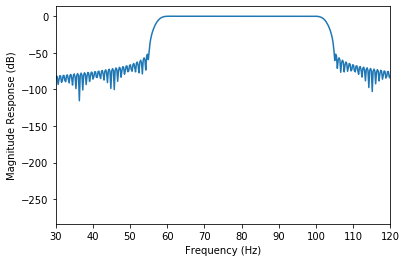

In [11]:
tw = 5  # transition bandwidth of 5 Hz
p = 2 # transition spline will be quadratic

numtaps = gsp.estimate_taps(fs, tw)

band_edges = [55, 60, 100, 105]
desired = [0, 1, 1, 0]
fg_filter = gsp.firdesign(numtaps, band_edges, desired, fs=fs, p=p)
filter_delay = (len(fg_filter) - 1) // 2

w, h = sig.freqz(fg_filter, worN=65536)
plt.plot(w/np.pi*fs/2, 20*np.log10(np.abs(h)))

plt.xlim(30, 120)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude Response (dB)")
#plt.ylim(-1, 1)

Here comes the fun part, we want to filter only the epochs of interest. We will create our output dataset
and then filter each segment, making sure to save the epoch information. First we need the timestamps vector (in units of actual time) so we know which part of the dataset to extract. Note that we have loaded the timestamps vector into memory, which usually isn't too much to ask for. But if it is somehow gigabytes in size, we can work out a solution.

In [8]:
with h5.File(out_filepath, 'r') as f:

    ts = f['timestamps'][:]
    n_channels, n_samples = f['chdata'].shape
    ndim = f['chdata'].ndim

Next we extract the relevant part of the dataset. We can select which channels we want by setting the `input_dim_restrictions` accordingly. We also notice that the original sampling rate is 30 kHz, which is massively oversampled for fast gamma. So we set the downsampling factor `ds` to 60 for an output sampling rate of 500 Hz. Finally we must correct for the delay of the FIR or it will not be aligned to the original data.

In [12]:
if intersection.isempty:
    print("No data contained inside the bounds of the EpochArray, doing nothing")
else:
    
    with h5.File(out_filepath, 'r') as infile:
        ds = 60
        desired_channels = [1, 4, 5]

        channel_axis = 0
        time_axis = 1
        input_dim_restrictions = [None] * ndim
        input_dim_restrictions[channel_axis] = np.s_[desired_channels]

        indices = []
        output_shape_list = [0] * ndim
        output_shape_list[channel_axis] = len(desired_channels)
        output_offsets = [0]
        new_fs = fs / ds

        for a_start, a_stop in intersection.data:
            frm, to = np.searchsorted(ts, (a_start, a_stop))
            if to > n_samples:
                to = n_samples

            indices.append((frm, to))
            shape, dtype = gsp.filter_data_fir(infile['chdata'],
                                               fg_filter,
                                               axis=time_axis,
                                               input_intypeex_bounds=[frm, to],
                                               output_index_bounds=[filter_delay, filter_delay + to - frm],
                                               describe_dims=True,
                                               ds=ds,
                                               input_dim_restrictions=input_dim_restrictions)
            output_offsets.append(output_offsets[-1] + shape[time_axis])
            output_shape_list[time_axis] += shape[time_axis]

        indices = np.array(indices, ndmin=2)
        new_epoch_data = np.zeros(indices.shape)

        # Now let's set up our output dataset
        ts_offset = 0
        new_filepath = '/home/jchu/DataHDD/install_07-09-2017_0200_0400_sd09-run.hdf5'
        with h5.File(new_filepath, 'w') as outfile:

            gamma_data = outfile.create_dataset('fast_gamma_data',
                                          shape=tuple(output_shape_list),
                                          dtype=dtype)
            new_ts = outfile.create_dataset('timestamps',
                                      shape=(output_shape_list[time_axis], ),
                                      dtype=ts.dtype)
            new_ts.attrs['sampling_rate'] = new_fs
            new_epochs = outfile.create_dataset('run_epochs',
                                          shape=(new_epoch_data.shape),
                                          dtype=new_epoch_data.dtype)

            for ii, (start, stop) in enumerate(indices):
                extracted_ts = ts[start:stop:ds]
                
                print(f"Diffs {np.diff(extracted_ts)}")
                new_ts[ts_offset:ts_offset+len(extracted_ts)] = extracted_ts
                ts_offset += len(extracted_ts)
                new_epoch_data[ii, 0] = extracted_ts[0]
                # remember EpochArray data MUST be half-open intervals!!
                new_epoch_data[ii, 1] = extracted_ts[-1] + 1/new_fs


                # finally ready to filter data!
                gsp.filter_data_fir(infile['chdata'],
                                    fg_filter,
                                    axis=time_axis,
                                    input_index_bounds=[start, stop],
                                    output_index_bounds=[filter_delay, filter_delay + stop - start],
                                    ds=ds,
                                    input_dim_restrictions=input_dim_restrictions,
                                    outarray=outfile['fast_gamma_data'],
                                    output_offset=output_offsets[ii])

            # write the run epochs to disk
            new_epochs[:] = new_epoch_data

First ind 16000, last ind 7349011, diff 7333011, total size 7365011
Output array should have shape (3, 122217) and dtype <f8
First ind 16000, last ind 2625890, diff 2609890, total size 2641890
Output array should have shape (3, 43499) and dtype <f8
First ind 16000, last ind 2625921, diff 2609921, total size 2641921
Output array should have shape (3, 43499) and dtype <f8
First ind 16000, last ind 9461683, diff 9445683, total size 9477683
Output array should have shape (3, 157429) and dtype <f8
First ind 16000, last ind 1134580, diff 1118580, total size 1150580
Output array should have shape (3, 18643) and dtype <f8
First ind 16000, last ind 2626025, diff 2610025, total size 2642025
Output array should have shape (3, 43501) and dtype <f8
First ind 16000, last ind 2626022, diff 2610022, total size 2642022
Output array should have shape (3, 43501) and dtype <f8
First ind 16000, last ind 10580390, diff 10564390, total size 10596390
Output array should have shape (3, 176074) and dtype <f8
Fi

# Optional

Run the following cell just to see that the data were filtered and stored in the right section of the array

In [18]:
# verify that we wrote the right data
with h5.File(out_filepath, 'r') as infile:
    with h5.File(new_filepath, 'r') as outfile:
        gamma_data = outfile['fast_gamma_data']
        ds = 60
        desired_channels = [1, 4, 5]

        channel_axis = 0
        time_axis = 1
        input_dim_restrictions = [None] * ndim
        input_dim_restrictions[channel_axis] = np.s_[desired_channels]

        indices = []
        output_shape_list = [0] * ndim
        output_shape_list[channel_axis] = len(desired_channels)
        output_offsets = [0]
        new_fs = fs / ds

        offset = 0
        for a_start, a_stop in intersection.data:
            frm, to = np.searchsorted(ts, (a_start, a_stop))
            if to > n_samples:
                to = n_samples

            indices.append((frm, to))
            shape, dtype = gsp.filter_data_fir(infile['chdata'],
                                               fg_filter,
                                               axis=time_axis,
                                               input_index_bounds=[frm, to],
                                               output_index_bounds=[filter_delay, filter_delay + to - frm],
                                               describe_dims=True,
                                               ds=ds,
                                               input_dim_restrictions=input_dim_restrictions)
            testoutput = gsp.filter_data_fir(infile['chdata'],
                                             fg_filter,
                                             axis=time_axis,
                                             input_index_bounds=[frm, to],
                                             output_index_bounds=[filter_delay, filter_delay + to - frm],
                                             ds=ds,
                                             input_dim_restrictions=input_dim_restrictions)
            assert np.allclose(testoutput, gamma_data[:, offset:offset + testoutput.shape[1]])
            offset += testoutput.shape[1]
            
print("Test passed!")

First ind 16000, last ind 7349011, diff 7333011, total size 7365011
Output array should have shape (3, 122217) and dtype <f8
First ind 16000, last ind 7349011, diff 7333011, total size 7365011
Allocated array of shape (3, 122217) with dtype <f8
first index 16000, last index 7349011
First segment: 32000, second segment 1016576, for a total of 1048576 FFT points
Total number of blocks: 8
Index 16000, first block to check: 0
Index 7349011 last block to check: 7
First offset 16000, last offset 232979
Wrote 16677 samples. Leftover 16. Next offset 44
Wrote 16943 samples. Leftover 12. Next offset 48
Wrote 16943 samples. Leftover 8. Next offset 52
Wrote 16943 samples. Leftover 4. Next offset 56
Wrote 16942 samples. Leftover 0. Next offset 0
Wrote 16943 samples. Leftover 56. Next offset 4
Wrote 16943 samples. Leftover 52. Next offset 8
last block to check!
Searching range 32008 to 264979
Wrote 122217 data points
First ind 16000, last ind 2625890, diff 2609890, total size 2641890
Output array sh